In [19]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests
import json
import random
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from pandas import DataFrame, Series
from patsy import dmatrices
from scipy import stats
from sklearn import metrics
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                             confusion_matrix, ConfusionMatrixDisplay, 
                             average_precision_score, balanced_accuracy_score, 
                             matthews_corrcoef, roc_auc_score)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance



In [109]:
import pandas as pd
import requests
import time

def get_nhl_percentages(start_season=2018, end_season=2024):
    """
    Fetch and aggregate NHL player percentages data across multiple seasons.
    
    Parameters:
    start_season: int, starting year (e.g., 2018 for 2018-19 season)
    end_season: int, ending year (e.g., 2024 for 2023-24 season)
    
    Returns:
    DataFrame with player percentages aggregated across seasons
    """
    all_data = []
    
    for year in range(start_season, end_season):
        season_id = f"{year}{year+1}"
        url = f'https://api.nhle.com/stats/rest/en/skater/percentages?limit=-1&cayenneExp=seasonId={season_id}'
        
        try:
            response = requests.get(url)
            if response.status_code == 200:
                season_data = response.json()
                if 'data' in season_data:
                    df_season = pd.DataFrame(season_data['data'])
                    df_season['season'] = f"{year}-{year+1}"
                    all_data.append(df_season)
                    print(f"Successfully fetched data for season {year}-{year+1}")
            else:
                print(f"Failed to fetch data for season {year}-{year+1}: Status code {response.status_code}")
                
            time.sleep(1)  # Be respectful to the API
            
        except Exception as e:
            print(f"Error fetching data for season {year}-{year+1}: {str(e)}")
    
    if all_data:
        # Combine all seasons
        df_combined = pd.concat(all_data, ignore_index=True)
        
        # Aggregate stats per player
        df_aggregated = df_combined.groupby('playerId').agg({
            'lastName': 'first',
            'usatPrecentageClose': 'mean',
            'usatPercentageTied': 'mean',
            'satPercentageClose': 'mean',
            'satPercentageTied': 'mean',
            'season': 'count'  # Number of seasons played
        }).reset_index(drop = True)
        
        return df_aggregated
    else:
        return None

# Example usage
df = get_nhl_percentages(2018, 2024)

if df is not None:
    # Display some summary statistics
    print("\nDataset Summary:")
    print(f"Total unique players: {len(df)}")
    print("\nAggregated Stats Summary:")
    print(df.describe())
    
    # Save to CSV
    df.to_csv('nhl_aggregated_stats.csv', index=False)

Successfully fetched data for season 2018-2019
Successfully fetched data for season 2019-2020
Successfully fetched data for season 2020-2021
Successfully fetched data for season 2021-2022
Successfully fetched data for season 2022-2023
Successfully fetched data for season 2023-2024

Dataset Summary:
Total unique players: 1558

Aggregated Stats Summary:
       usatPrecentageClose  usatPercentageTied  satPercentageClose  \
count          1557.000000         1546.000000         1555.000000   
mean              0.478455            0.477650            0.477054   
std               0.084694            0.104980            0.075413   
min               0.000000            0.000000            0.000000   
25%               0.448333            0.445000            0.447708   
50%               0.485500            0.485196            0.484400   
75%               0.515857            0.520333            0.514208   
max               1.000000            1.000000            1.000000   

       satPerce

In [111]:
df.columns

Index(['lastName', 'usatPrecentageClose', 'usatPercentageTied',
       'satPercentageClose', 'satPercentageTied', 'season'],
      dtype='object')

In [117]:
df.loc[df['lastName'] == 'Marchand']

,lastName,usatPrecentageClose,usatPercentageTied,satPercentageClose,satPercentageTied,season
107,Marchand,0.5755,0.58,0.569667,0.576,6


In [53]:
percentages_url = 'https://api.nhle.com/stats/rest/en/skater/percentages?limit=-1&cayenneExp=seasonId=20232024'
percentages_resp = requests.get(percentages_url)
percentages_json = percentages_resp.json()

In [54]:
df_percentages = DataFrame(percentages_json['data'])

In [57]:
df_percentages

,gamesPlayed,lastName,playerId,positionCode,satPercentage,satPercentageAhead,satPercentageBehind,satPercentageClose,satPercentageTied,satRelative,...,skaterShootingPlusSavePct5v5,teamAbbrevs,timeOnIcePerGame5v5,usatPercentage,usatPercentageAhead,usatPercentageBehind,usatPercentageTied,usatPrecentageClose,usatRelative,zoneStartPct5v5
0,64,Necas,8480039,C,0.528,0.519,0.551,0.525,0.525,-0.012,...,1.026,CAR,819.937,0.529,0.525,0.542,0.526,0.525,-0.006,0.494
1,49,Deslauriers,8475235,L,0.448,0.352,0.513,0.435,0.440,-0.055,...,0.970,ANA,661.122,0.448,0.356,0.498,0.454,0.433,-0.045,0.344
2,55,Heiskanen,8480036,D,0.526,0.470,0.528,0.537,0.568,-0.007,...,0.979,DAL,1148.400,0.524,0.492,0.501,0.574,0.543,-0.004,0.501
3,78,Johnson,8474870,C,0.504,0.464,0.553,0.535,0.522,-0.010,...,1.011,TBL,654.346,0.507,0.492,0.523,0.516,0.544,-0.008,0.533
4,54,Soucy,8477369,D,0.433,0.443,0.442,0.443,0.417,-0.047,...,1.065,MIN,836.203,0.449,0.472,0.440,0.434,0.463,-0.037,0.347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,28,Asplund,8479335,C,0.443,0.411,0.476,0.421,0.408,-0.012,...,0.996,BUF,707.500,0.436,0.402,0.487,0.378,0.403,-0.010,0.426
941,2,Gauthier,8477512,C,0.208,0.428,0.500,0.142,0.066,-0.281,...,1.000,ARI,404.500,0.176,0.333,0.500,0.000,0.133,-0.250,0.333
942,33,Jones,8478452,D,0.491,0.451,0.568,0.473,0.460,-0.009,...,0.958,EDM,773.242,0.500,0.472,0.561,0.466,0.475,0.006,0.546
943,45,Jankowski,8476873,C,0.447,0.448,0.423,0.445,0.464,-0.075,...,1.017,PIT,516.622,0.456,0.470,0.467,0.437,0.442,-0.066,0.303


In [39]:
df_percentages = DataFrame(percentages_json['data'])
df_percentages_filtered = df_percentages.loc[(df_percentages['positionCode'] != 'D') & (df_percentages['gamesPlayed'] >= 20)]
df_percentages_filtered = df_percentages_filtered.reset_index(drop=True)
df_percentages_filtered.drop(['skaterSavePct5v5', 'seasonId','shootingPct5v5', 'timeOnIcePerGame5v5', 'zoneStartPct5v5', 'satPercentage', 'satPercentageBehind', 'satPercentageAhead', 'satRelative', 'skaterShootingPlusSavePct5v5', 'usatPercentage', 'usatPercentageAhead', 'usatPercentageBehind', 'usatRelative'], axis=1, inplace=True)
df_percentages_filtered = df_percentages_filtered[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'shootsCatches','satPercentageClose',
 'satPercentageTied','usatPercentageTied', 'usatPrecentageClose']]
df_percentages_filtered['tiedPerformance'] = (df_percentages_filtered['usatPercentageTied'] + df_percentages_filtered['satPercentageTied'])/2
df_percentages_filtered['closePerformance'] = (df_percentages_filtered['usatPrecentageClose'] + df_percentages_filtered['satPercentageClose'])/2

In [4]:
df_percentages_filtered

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,usatPrecentageClose,tiedPerformance,closePerformance
0,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,0.464,0.436,0.401,0.436,0.4185,0.4500
1,8475763,Kevin Hayes,Hayes,R,STL,79,L,0.450,0.443,0.430,0.436,0.4365,0.4430
2,8471698,T.J. Oshie,Oshie,R,WSH,56,R,0.433,0.416,0.411,0.431,0.4135,0.4320
3,8482259,Bobby McMann,McMann,C,TOR,56,L,0.523,0.518,0.509,0.530,0.5135,0.5265
4,8480748,Kiefer Sherwood,Sherwood,L,NSH,74,R,0.520,0.535,0.534,0.522,0.5345,0.5210
...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,8481553,Bobby Brink,Brink,R,PHI,57,R,0.475,0.479,0.508,0.502,0.4935,0.4885
470,8477951,Nick Schmaltz,Schmaltz,C,ARI,79,R,0.515,0.483,0.484,0.509,0.4835,0.5120
471,8478233,Andrew Mangiapane,Mangiapane,L,CGY,75,L,0.517,0.506,0.537,0.542,0.5215,0.5295
472,8482652,Walker Duehr,Duehr,R,CGY,40,R,0.429,0.491,0.512,0.429,0.5015,0.4290


In [5]:
summary_url = 'https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId=20232024'
summary_resp = requests.get(summary_url)
summary_json = summary_resp.json()

In [33]:
df_summary = DataFrame(summary_json['data'])
df_summary_filtered = df_summary.loc[(df_summary['positionCode'] != 'D') & (df_summary['gamesPlayed'] >= 20)]
df_summary_filtered = df_summary_filtered.reset_index(drop=True)
df_summary_filtered.drop(['assists', 'evGoals', 'evPoints', 'faceoffWinPct', 'penaltyMinutes', 'plusMinus', 'pointsPerGame', 'ppGoals', 'ppPoints', 'shPoints','shootingPct', 'shootsCatches', 'shots', 'timeOnIcePerGame', 'seasonId'], axis=1, inplace=True)
df_summary_filtered = df_summary_filtered[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'goals', 'gameWinningGoals','otGoals', 'points']]
df_summary_filtered['clutchGoals'] = df_summary_filtered['gameWinningGoals'] + df_summary_filtered['otGoals']
df_summary_filtered['clutchgoalsRatio'] = df_summary_filtered['clutchGoals'] / np.maximum(df_summary_filtered['goals'],1)

In [35]:
df_summary_filtered

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,goals,gameWinningGoals,otGoals,points,clutchGoals,clutchgoalsRatio
0,8480039,Martin Necas,Necas,C,CAR,88,28,3,2,62,5,0.178571
1,8478028,Fredrik Olofsson,Olofsson,L,COL,57,3,1,0,9,1,0.333333
2,8475763,Kevin Hayes,Hayes,R,STL,79,13,2,0,29,2,0.153846
3,8471698,T.J. Oshie,Oshie,R,WSH,56,12,4,0,26,4,0.333333
4,8482259,Bobby McMann,McMann,C,TOR,56,15,0,0,24,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
469,8482125,Alexander Holtz,Holtz,R,NJD,82,16,3,0,28,3,0.187500
470,8482157,Will Cuylle,Cuylle,L,NYR,97,14,2,0,23,2,0.142857
471,8479367,William Lockwood,Lockwood,R,FLA,26,0,0,0,1,0,0.000000
472,8480068,Ryan Poehling,Poehling,C,PHI,77,11,1,0,28,1,0.090909


In [37]:
df_players_merged = pd.merge(df_percentages_filtered, df_summary_filtered, on = 'playerId', how = 'right', suffixes=('', '_x'))

In [39]:
df_players_merged.columns

Index(['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs',
       'gamesPlayed', 'shootsCatches', 'satPercentageClose',
       'satPercentageTied', 'usatPercentageTied', 'usatPrecentageClose',
       'tiedPerformance', 'closePerformance', 'skaterFullName_x', 'lastName_x',
       'positionCode_x', 'teamAbbrevs_x', 'gamesPlayed_x', 'goals',
       'gameWinningGoals', 'otGoals', 'points', 'clutchGoals',
       'clutchgoalsRatio'],
      dtype='object')

In [41]:
df_players_merged.drop(columns = ['skaterFullName_x', 'lastName_x', 'positionCode_x', 'teamAbbrevs_x', 'gamesPlayed_x'], axis=1, inplace=True)

In [43]:
df_players_merged

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,usatPrecentageClose,tiedPerformance,closePerformance,goals,gameWinningGoals,otGoals,points,clutchGoals,clutchgoalsRatio
0,8480039,Martin Necas,Necas,C,CAR,88,R,0.609,0.611,0.600,0.599,0.6055,0.6040,28,3,2,62,5,0.178571
1,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,0.464,0.436,0.401,0.436,0.4185,0.4500,3,1,0,9,1,0.333333
2,8475763,Kevin Hayes,Hayes,R,STL,79,L,0.450,0.443,0.430,0.436,0.4365,0.4430,13,2,0,29,2,0.153846
3,8471698,T.J. Oshie,Oshie,R,WSH,56,R,0.433,0.416,0.411,0.431,0.4135,0.4320,12,4,0,26,4,0.333333
4,8482259,Bobby McMann,McMann,C,TOR,56,L,0.523,0.518,0.509,0.530,0.5135,0.5265,15,0,0,24,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,8482125,Alexander Holtz,Holtz,R,NJD,82,R,0.467,0.447,0.437,0.456,0.4420,0.4615,16,3,0,28,3,0.187500
472,8482157,Will Cuylle,Cuylle,L,NYR,97,L,0.485,0.493,0.516,0.501,0.5045,0.4930,14,2,0,23,2,0.142857
473,8479367,William Lockwood,Lockwood,R,FLA,26,R,0.554,0.531,0.485,0.530,0.5080,0.5420,0,0,0,1,0,0.000000
474,8480068,Ryan Poehling,Poehling,C,PHI,77,L,0.484,0.448,0.497,0.524,0.4725,0.5040,11,1,0,28,1,0.090909


In [45]:
df_players_merged.rename(columns={'usatPrecentageClose': 'usatPercentageClose'}, inplace=True)

In [47]:
df_players_merged

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,usatPercentageClose,tiedPerformance,closePerformance,goals,gameWinningGoals,otGoals,points,clutchGoals,clutchgoalsRatio
0,8480039,Martin Necas,Necas,C,CAR,88,R,0.609,0.611,0.600,0.599,0.6055,0.6040,28,3,2,62,5,0.178571
1,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,0.464,0.436,0.401,0.436,0.4185,0.4500,3,1,0,9,1,0.333333
2,8475763,Kevin Hayes,Hayes,R,STL,79,L,0.450,0.443,0.430,0.436,0.4365,0.4430,13,2,0,29,2,0.153846
3,8471698,T.J. Oshie,Oshie,R,WSH,56,R,0.433,0.416,0.411,0.431,0.4135,0.4320,12,4,0,26,4,0.333333
4,8482259,Bobby McMann,McMann,C,TOR,56,L,0.523,0.518,0.509,0.530,0.5135,0.5265,15,0,0,24,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,8482125,Alexander Holtz,Holtz,R,NJD,82,R,0.467,0.447,0.437,0.456,0.4420,0.4615,16,3,0,28,3,0.187500
472,8482157,Will Cuylle,Cuylle,L,NYR,97,L,0.485,0.493,0.516,0.501,0.5045,0.4930,14,2,0,23,2,0.142857
473,8479367,William Lockwood,Lockwood,R,FLA,26,R,0.554,0.531,0.485,0.530,0.5080,0.5420,0,0,0,1,0,0.000000
474,8480068,Ryan Poehling,Poehling,C,PHI,77,L,0.484,0.448,0.497,0.524,0.4725,0.5040,11,1,0,28,1,0.090909


In [49]:
percentages  = ['satPercentageClose', 'satPercentageTied','usatPercentageTied', 'usatPercentageClose', 'tiedPerformance', 'closePerformance', 'clutchgoalsRatio']

for stat in percentages:
    df_players_merged[stat] *= 100


In [51]:
df_players_merged[['tiedPerformance', 'closePerformance', 'clutchgoalsRatio']].describe(percentiles=[0.75, 0.8, 0.9])

,tiedPerformance,closePerformance,clutchgoalsRatio
count,476.000000,476.000000,476.000000
mean,49.333088,49.260504,14.775629
std,5.277524,4.856933,12.319454
min,35.000000,34.900000,0.000000
50%,49.575000,49.650000,14.550265
75%,53.050000,52.600000,22.617302
80%,54.000000,53.300000,25.000000
90%,55.800000,54.925000,31.009615
max,63.150000,61.650000,66.666667


In [103]:
gameWinningGoalsQuantile = df_players_merged['clutchgoalsRatio'].quantile(0.8)

def binary_clutchness(row):
    clutchness = (row['goals'] >= 25)
    if clutchness:
        return 1
    else:
        return 0
        
df_players_merged['clutch_performance'] = df_players_merged.apply(binary_clutchness, axis=1)

In [105]:
df_players_merged['clutch_performance'].value_counts()

clutch_performance
0    377
1     99
Name: count, dtype: int64

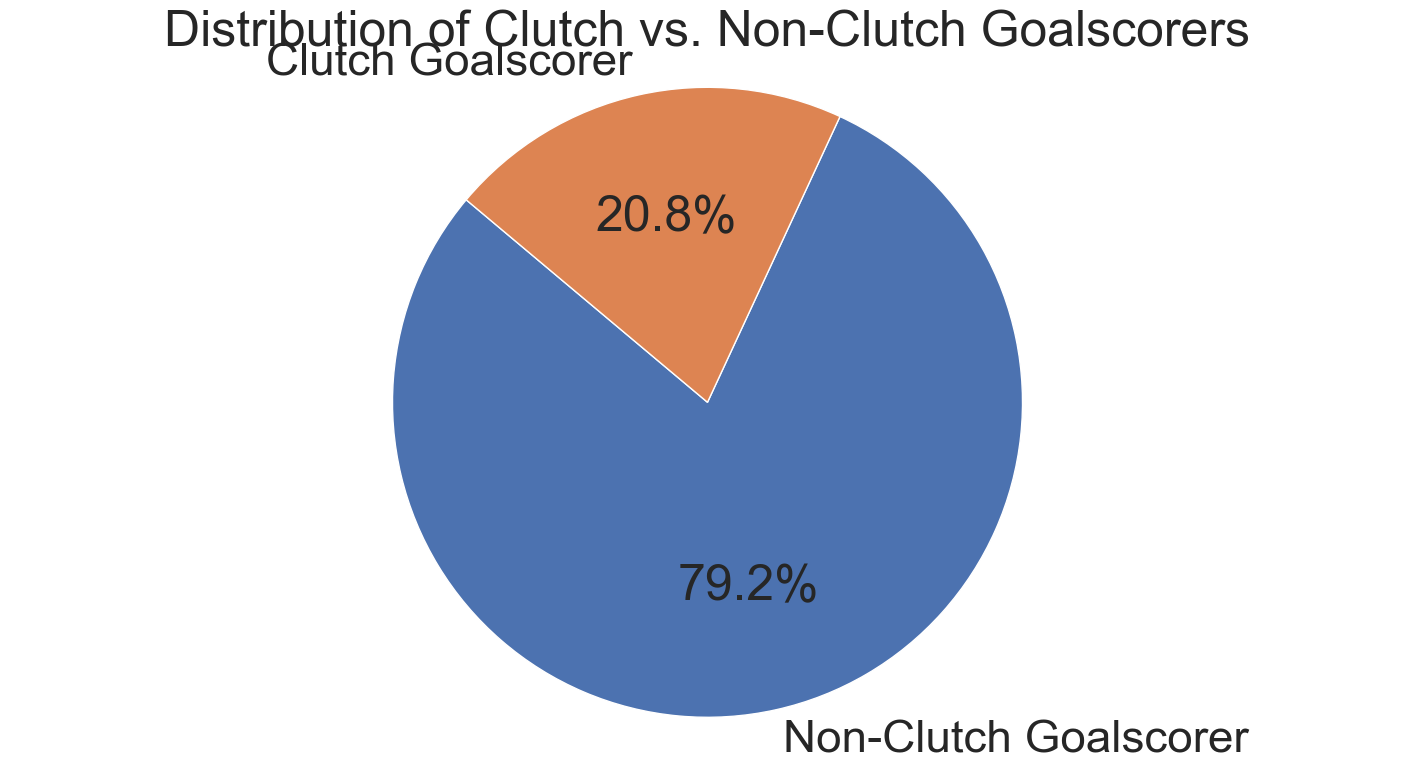

In [107]:
key = ['Non-Clutch Goalscorer', 'Clutch Goalscorer',]

plt.pie(df_players_merged['clutch_performance'].value_counts(), labels=key, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Clutch vs. Non-Clutch Goalscorers')
plt.axis('equal') 
plt.show()

In [19]:
x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = ['clutch_performance']
train, test = train_test_split(df_players_merged, test_size = 0.3)

xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='mlogloss')
xgb_model.fit(train[x_var], train[y_var])

test['xgb_clutch_type'] = xgb_model.predict(test[x_var])
test['xgb_correct'] = (test['xgb_clutch_type'] == test['clutch_performance'])
xgb_accuracy = test['xgb_correct'].mean()
xgb_accuracy

0.972027972027972

In [20]:
'''import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_score, recall_score, average_precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from scipy.stats import friedmanchisquare

x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = 'clutch_performance'

x = df_players_merged[x_var]
y = df_players_merged[y_var]

models = {
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators = 100),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss')
}

metrics = {name: {'precision': [], 'recall': [], 'auc_pr': [], 'f1_score': []} for model_name in models}
def evaluate_model(model, x, y):
    precision_scores = []
    recall_scores = []
    auc_pr_scores = []
    f1_scores = []
    
    skf = StratifiedKFold(n_splits = 5)

    for train_index, test_index in skf.split(x, y):
        x_train_fold, x_test_fold = x.iloc[train_index], x.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        model.fit(x_train_fold, y_train_fold)
        y_true = y_test_fold

        y_pred = model.predict(x_test_fold)
        y_pred_proba = model.predict_proba(x_test_fold)[:, 1]
            

        precision_scores.append(precision_score(y_true, y_pred))
        recall_scores.append(recall_score(y_true, y_pred))
        auc_pr_scores.append(average_precision_score(y_true, y_pred_proba))
        f1_scores.append(f1_score(y_true, y_pred))

    return {
        'precision': precision_scores,
        'recall': recall_scores,
        'auc_pr': auc_pr_scores,
        'f1_score': f1_scores
    }


for model_name, model in models.items():
    results = evaluate_model(model, x, y)
    for metric in metrics[model_name]:
        metrics[model_name][metric] = results[metric]

data_for_tests = {
    'precision': [metrics[name]['precision'] for name in models],
    'recall': [metrics[name]['recall'] for name in models],
    'auc_pr': [metrics[name]['auc_pr'] for name in models],
    'f1_score': [metrics[name]['f1_score'] for name in models],
}

for metric, data in data_for_tests.items():
    stat, p = friedmanchisquare(*data)
    print(f'Friedman test for {metric.capitalize()}: statistic={stat}, p-value={p}')''

SyntaxError: incomplete input (1777348547.py, line 1)

In [ ]:
'''for model_name in metrics.keys():
    print(f"{model_name} recall: {metrics[model_name]['recall']}")'''
    

In [ ]:
'''import pandas as pd

# Extract precision scores
precision_data = []

for model_name, metrics_values in metrics.items():
    precision_scores = metrics_values['recall']
    
    for fold_index, score in enumerate(precision_scores):
        precision_data.append({
            'Model': model_name,
            'Fold': fold_index + 1,
            'Precision': score
        })

precision_df = pd.DataFrame(precision_data)

knn_precision = precision_df.loc[precision_df['Model'] == 'KNN', 'Precision'].values
random_forest_precision = precision_df.loc[precision_df['Model'] == 'Random Forest', 'Precision'].values
xgboost_forest_precision = precision_df.loc[precision_df['Model'] == 'XGBoost', 'Precision'].values

res = friedmanchisquare(knn_precision, random_forest_precision, xgboost_forest_precision)
print(res.statistic)
print(res.pvalue)

precision_df['Rank'] = precision_df.groupby('Fold')['Precision'].rank(ascending=False)

rank_sum = precision_df.groupby('Model')['Rank'].sum().reset_index()
rank_sum.columns = ['Model', 'Rank_Sum']
rank_sum['Sum Squared'] = rank_sum['Rank_Sum'] ** 2

chi_square = 12 / (10 * 3 * (3 + 1)) * rank_sum['Sum Squared'].sum() - 3 * 10 * (3 + 1)

print(chi_square)
'''

Friedman test for Precision: statistic=10.173913043478276, p-value=0.006176790235910856

Metrics Summary for Precision (p < 0.05):
                    mean
KNN            0.798636
Random Forest  0.796890
XGBoost        0.712716
                    KNN  Random Forest   XGBoost
KNN            1.000000       0.979620  0.549135
Random Forest  0.979620       1.000000  0.549135
XGBoost        0.549135       0.549135  1.000000
Friedman test for Recall: statistic=9.08333333333334, p-value=0.0106556323585439

Metrics Summary for Recall (p < 0.05):
                    mean
KNN            0.535556
Random Forest  0.636667
XGBoost        0.645556
                    KNN  Random Forest   XGBoost
KNN            1.000000       0.447837  0.447837
Random Forest  0.447837       1.000000  0.916342
XGBoost        0.447837       0.916342  1.000000
Friedman test for Auc_pr: statistic=12.200000000000017, p-value=0.0022428677194857843

Metrics Summary for Auc_pr (p < 0.05):
                    mean
KNN        

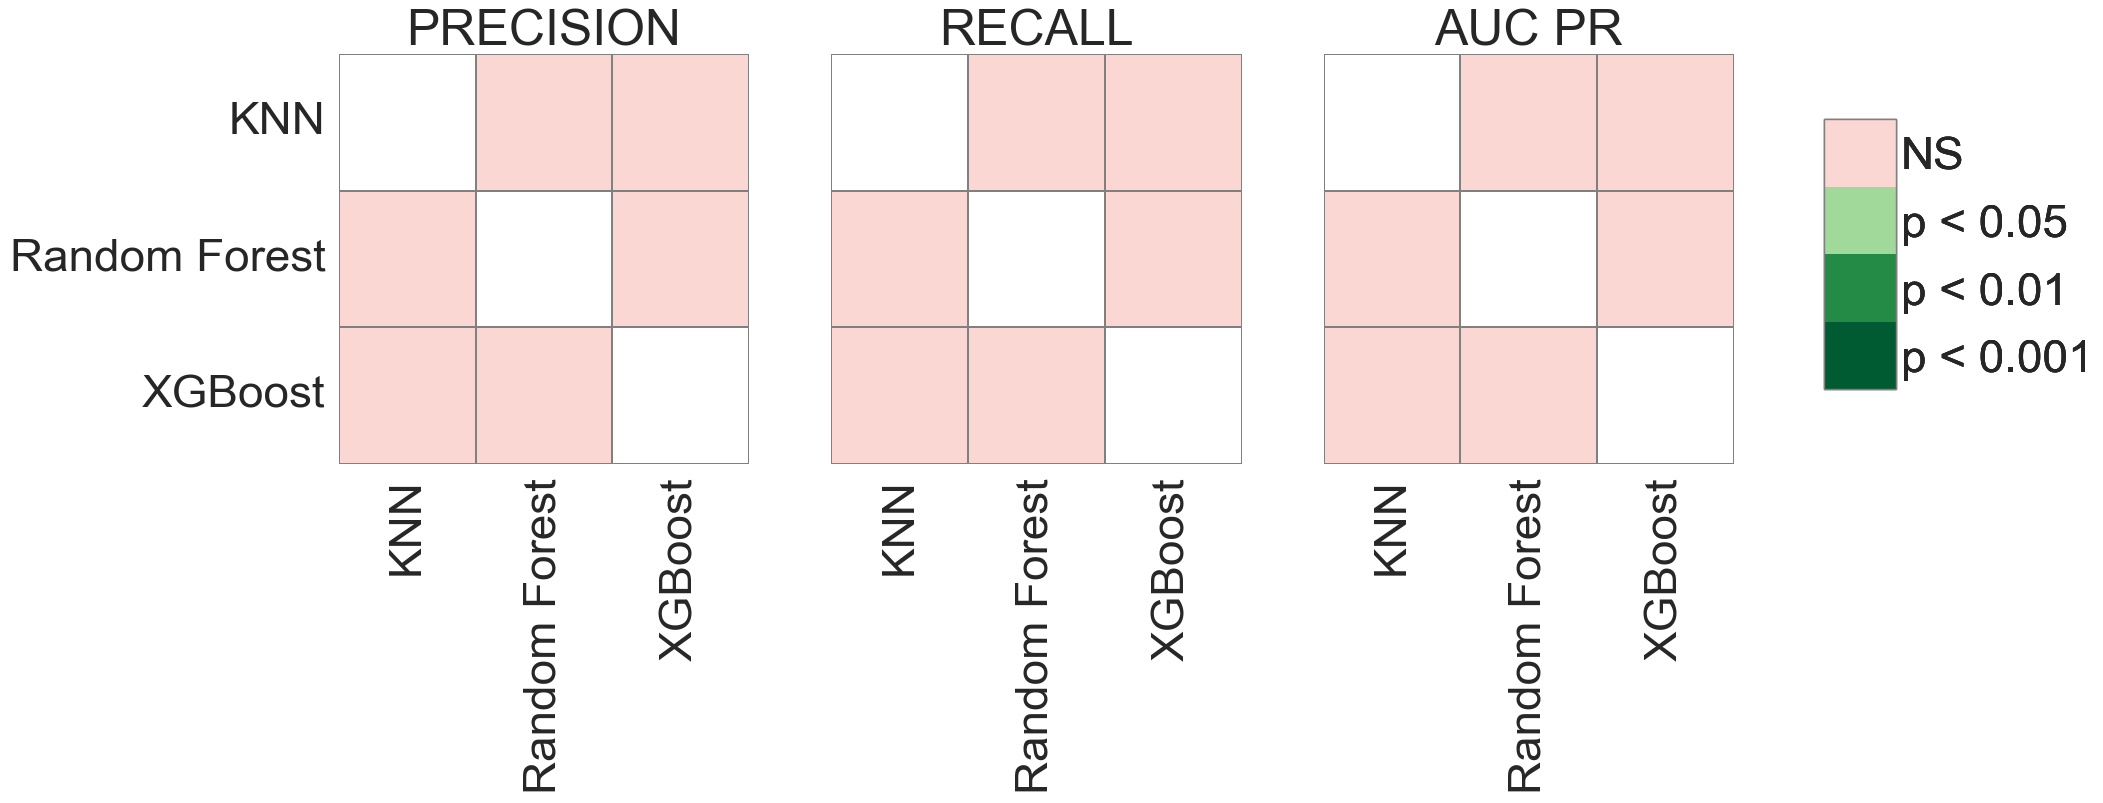

In [109]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, average_precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
import scikit_posthocs as sp


x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = 'clutch_performance'

x = df_players_merged[x_var]
y = df_players_merged[y_var]

models = {
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators = 100),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss')
    }

metrics_combined =  {'precision': [], 
     'recall': [], 
     'auc_pr': [], 
     'f1_score': []}

skf = StratifiedKFold(n_splits = 10)

def evaluate_model(model, x, y):
    precision_scores = []
    recall_scores = []
    auc_pr_scores = []
    f1_scores = []
    
    for train_index, test_index in skf.split(x, y):
        x_train_fold, x_test_fold = x.iloc[train_index], x.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
        model.fit(x_train_fold, y_train_fold)
        y_true = y_test_fold
    
        y_pred = model.predict(x_test_fold)
        y_pred_proba = model.predict_proba(x_test_fold)[:, 1]
                
    
        precision_scores.append(precision_score(y_true, y_pred))
        recall_scores.append(recall_score(y_true, y_pred))
        auc_pr_scores.append(average_precision_score(y_true, y_pred_proba))
        f1_scores.append(f1_score(y_true, y_pred))

    results = {
        'precision': precision_scores,
        'recall': recall_scores,
        'auc_pr': auc_pr_scores,
        'f1_score': f1_scores
    }
               
    return results
    
for model_name, model in models.items():
    scores = evaluate_model(model, x, y)
    for metric in scores:
        metrics_combined[metric].append(scores[metric])

sns.set(rc={'figure.figsize': (18, 9)}, font_scale = 3)
figure, axes = plt.subplots(1, 3, sharex = True, sharey= True)

i = 0

for name in metrics_combined:
    stat, p = friedmanchisquare(*metrics_combined[name])
    print(f'Friedman test for {name.capitalize()}: statistic={stat}, p-value={p}')
    
    if p < 0.05:
        df_scores = pd.DataFrame(metrics_combined[name]).T
        df_scores.columns = models.keys() 

        metrics_summary = df_scores.agg(['mean']).T
        print(f'\nMetrics Summary for {name.capitalize()} (p < 0.05):\n', metrics_summary)

        
        df_long = df_scores.melt(var_name='Model', value_name='Score')
        
        df = sp.posthoc_conover(df_long, group_col='Model', val_col='Score', p_adjust='holm')
        print(df)

        similarity_matrix = pd.DataFrame(df, index = models.keys())

        heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5',  'square': True}

        sub_ax, sub_c = sp.sign_plot(df, **heatmap_args, ax=axes[i])
        sub_ax.set_title(name.replace("_", " ").upper())
        i += 1
        if i >= 3:
            break

plt.show()

In [110]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = 'clutch_performance'

X = df_players_merged[x_var]
y = df_players_merged[y_var]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)

xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [111]:
from sklearn.model_selection import cross_validate

scoring = ['accuracy', 'precision', 'recall', 'f1', 'average_precision']

scores = cross_validate(xgb_model, X, y, cv=5, scoring=scoring)

df = pd.DataFrame.from_dict(scores)

df.mean()

fit_time                  0.105020
score_time                0.032894
test_accuracy             0.861294
test_precision            0.705873
test_recall               0.606316
test_f1                   0.649440
test_average_precision    0.700155
dtype: float64

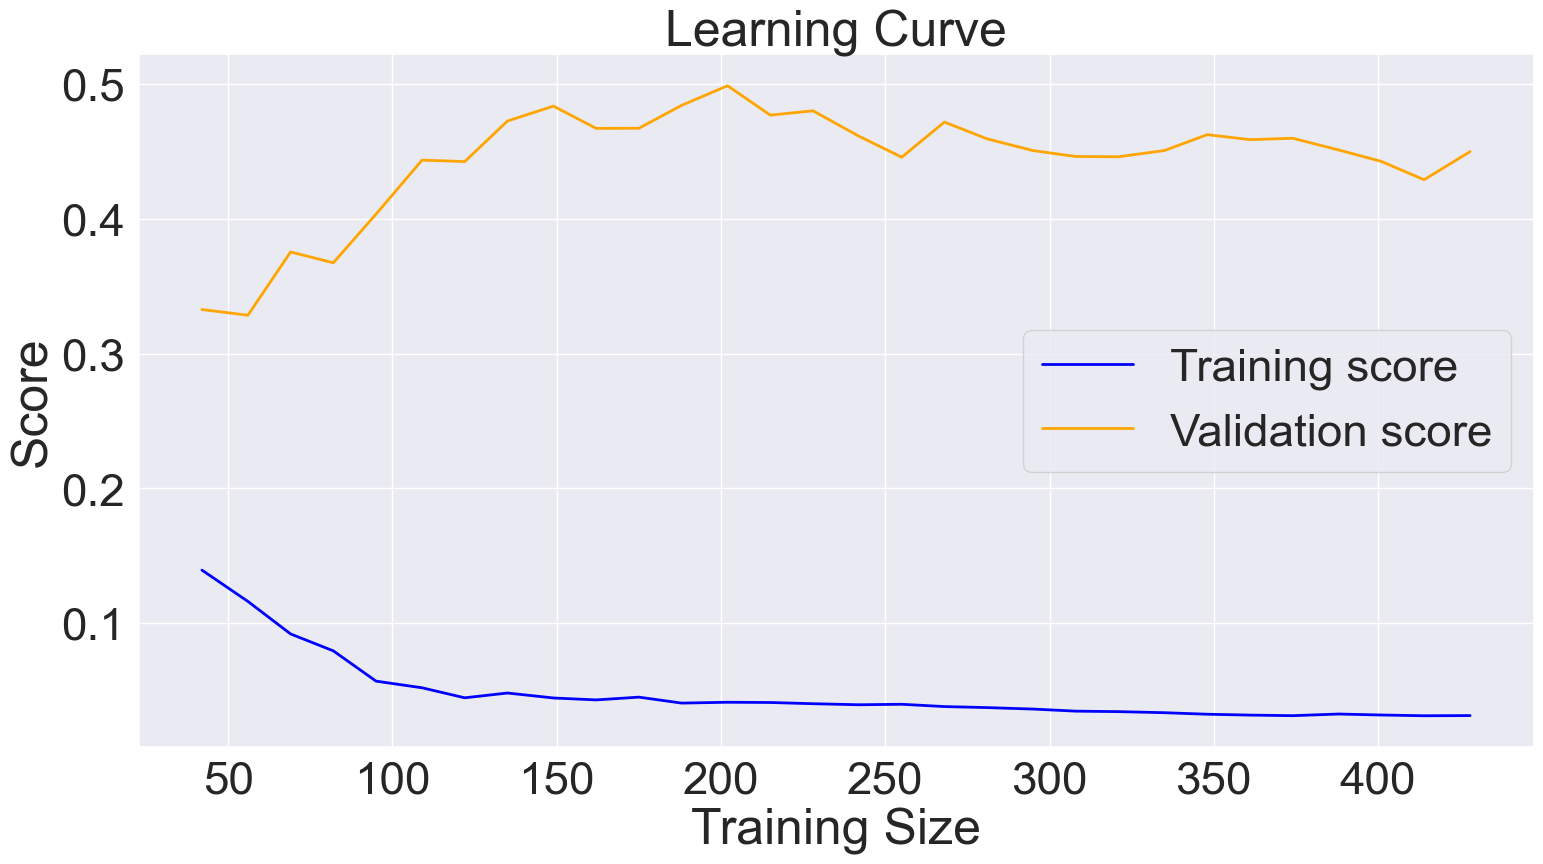

In [112]:
from sklearn.model_selection import learning_curve

cv = StratifiedKFold(n_splits=10)

train_sizes, train_scores, valid_scores = learning_curve(
    xgb_model, X, y,
    train_sizes=np.linspace(0.1, 1, 30), 
    cv=cv, 
    scoring='neg_log_loss',  
    n_jobs=-1  
)

train_scores_mean = -np.mean(train_scores, axis=1)
valid_scores_mean = -np.mean(valid_scores, axis=1)
train_scores_std = -np.std(train_scores, axis=1)
valid_scores_std = -np.std(valid_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', linewidth=2)
plt.plot(train_sizes, valid_scores_mean, label='Validation score', color='orange', linewidth=2)
plt.legend() 
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.show()

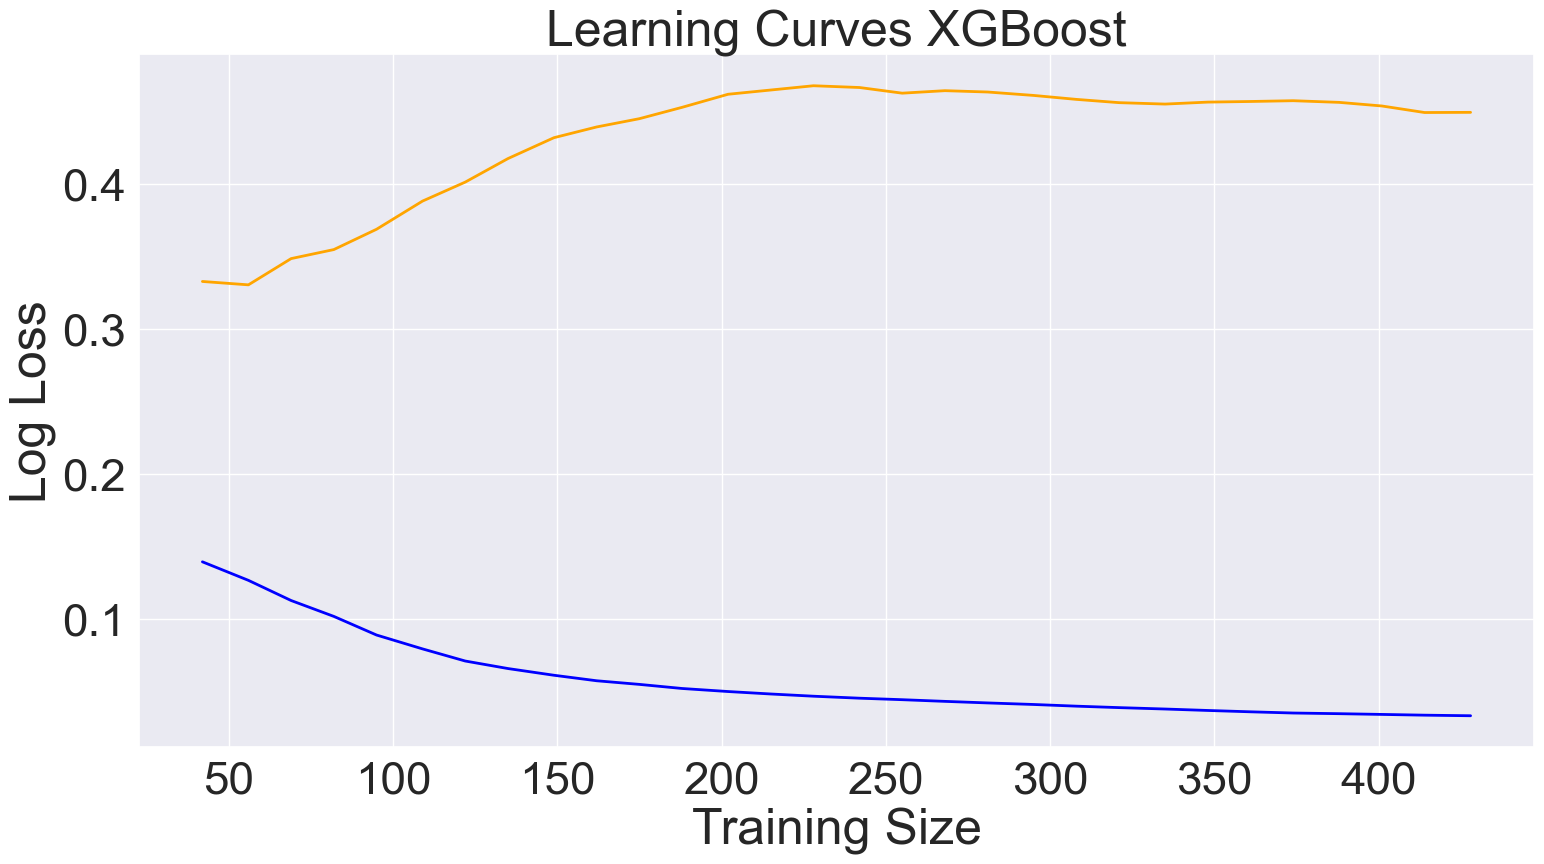

In [113]:
train_scores_smooth = pd.Series(train_scores_mean).ewm(span=10).mean()
valid_scores_smooth = pd.Series(valid_scores_mean).ewm(span=10).mean()

plt.plot(train_sizes, train_scores_smooth, label='Training score', color='blue', linewidth=2)
plt.plot(train_sizes, valid_scores_smooth, label='Cross-validation score', color='orange', linewidth=2)

plt.xlabel('Training Size')
plt.ylabel('Log Loss')
plt.title('Learning Curves XGBoost')
plt.show()

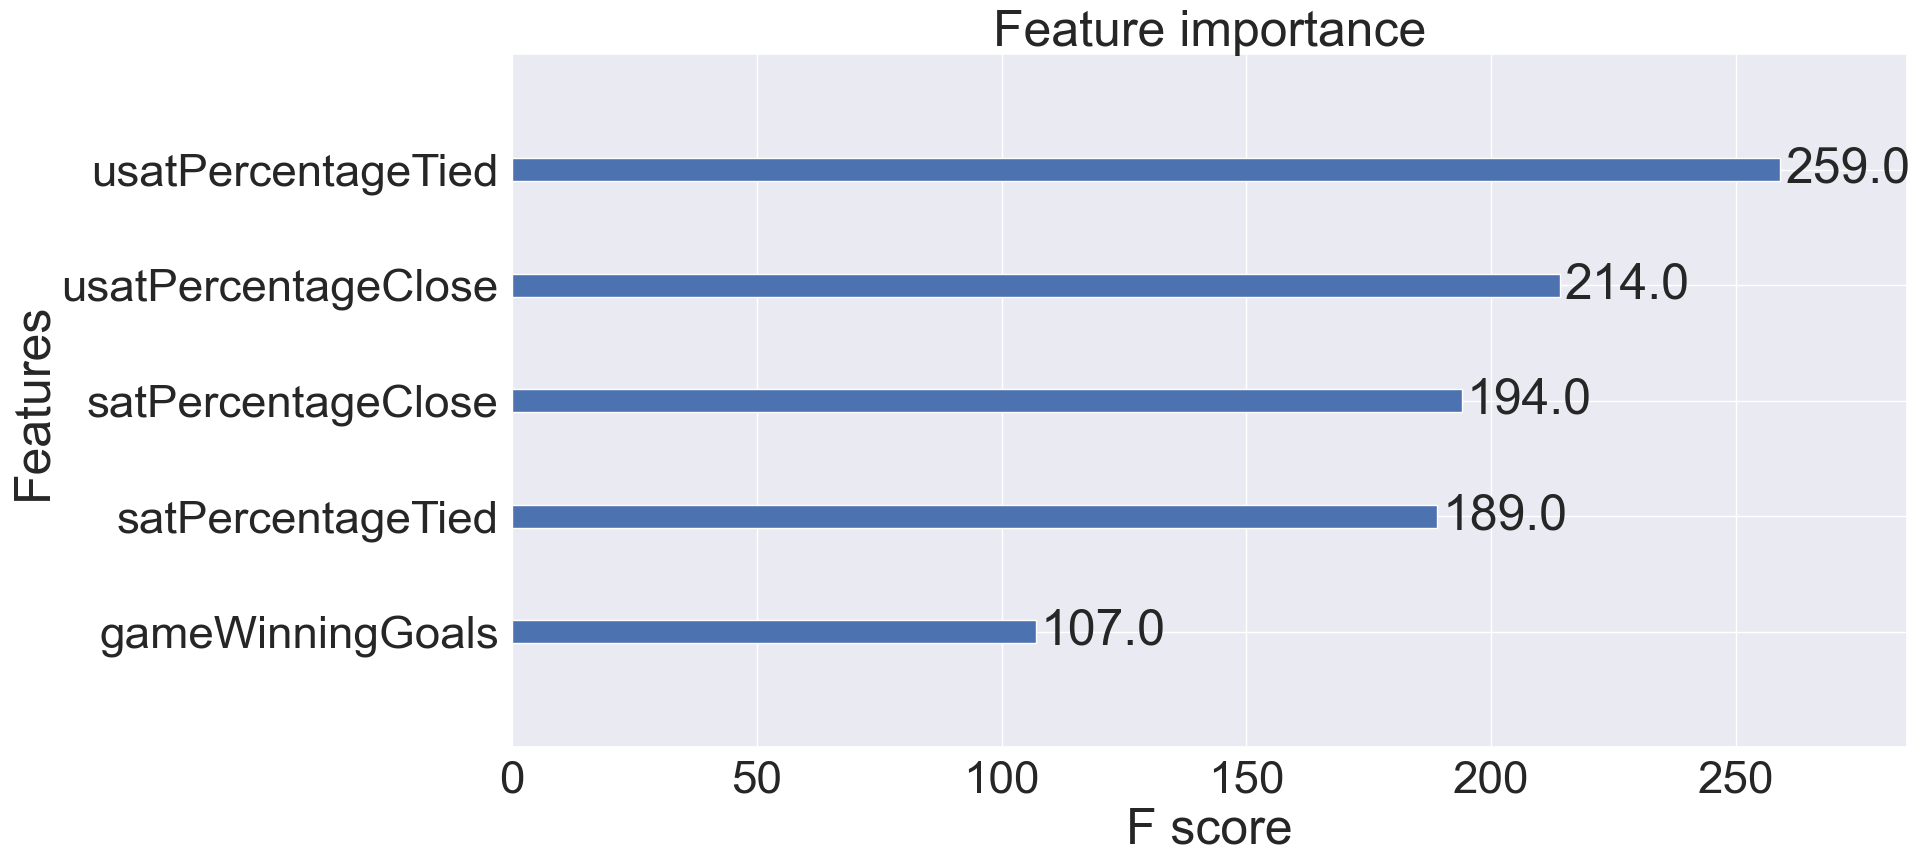

In [114]:
plot_importance(xgb_model)
plt.show()

In [115]:
x_var_adjusted = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageTied', 'satPercentageClose']
y_var = 'clutch_performance'

X_adjusted = df_players_merged[x_var_adjusted]
y = df_players_merged[y_var]

train_x, test_x, train_y, test_y = train_test_split(X_adjusted, y, test_size=0.2, random_state=50)

xgb_model_adjusted = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model_adjusted.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [116]:
from skopt import BayesSearchCV
import xgboost as xgb
import time
import math

scale_pos_weight = math.sqrt((df_players_merged['clutch_performance'] == 0).sum() / (df_players_merged['clutch_performance'] == 1).sum())

param_grid = {
    'max_depth': [1,3,5],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [scale_pos_weight],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.1, 0.3, 0.6, 0.8, 1.0],
    'reg_alpha': [0.1, 0.5, 1.0],
    'reg_lambda': [0.1, 0.5, 1.0],
    'colsample_bytree': [0.3, 0.5, 0.8] 
}

fit_params = {
'early_stopping_rounds': 15,
}


[0]	validation_0-logloss:0.53382	validation_1-logloss:0.54823
[1]	validation_0-logloss:0.51093	validation_1-logloss:0.52623
[2]	validation_0-logloss:0.49380	validation_1-logloss:0.51077
[3]	validation_0-logloss:0.48073	validation_1-logloss:0.49686
[4]	validation_0-logloss:0.46362	validation_1-logloss:0.48064
[5]	validation_0-logloss:0.44889	validation_1-logloss:0.47390
[6]	validation_0-logloss:0.43788	validation_1-logloss:0.45816
[7]	validation_0-logloss:0.42892	validation_1-logloss:0.44259
[8]	validation_0-logloss:0.42121	validation_1-logloss:0.43583
[9]	validation_0-logloss:0.41222	validation_1-logloss:0.42428
[10]	validation_0-logloss:0.40760	validation_1-logloss:0.41751
[11]	validation_0-logloss:0.40274	validation_1-logloss:0.41282
[12]	validation_0-logloss:0.39705	validation_1-logloss:0.40645
[13]	validation_0-logloss:0.39210	validation_1-logloss:0.39897
[14]	validation_0-logloss:0.38662	validation_1-logloss:0.39554
[15]	validation_0-logloss:0.38325	validation_1-logloss:0.38993
[1

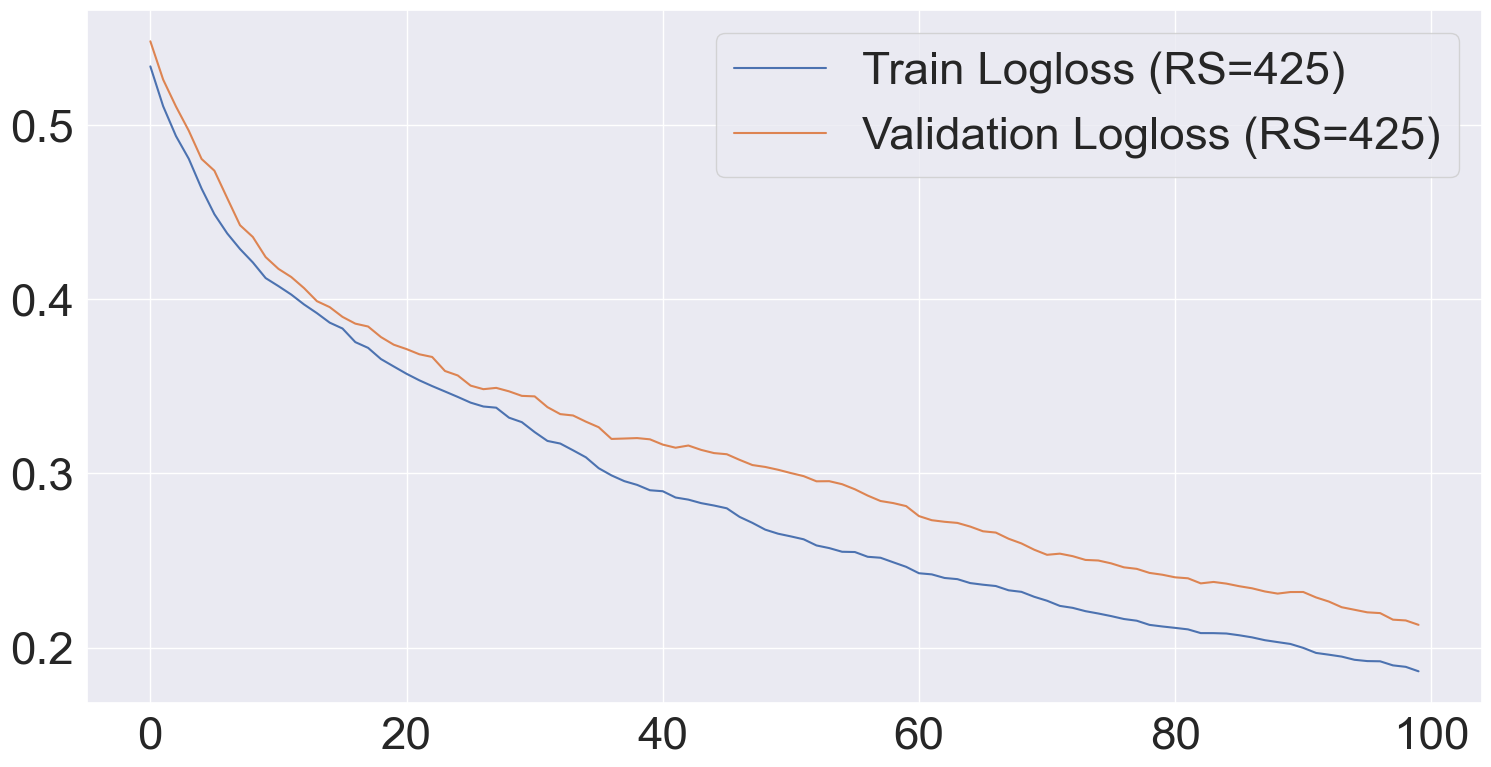

[0]	validation_0-logloss:0.52627	validation_1-logloss:0.54687
[1]	validation_0-logloss:0.50585	validation_1-logloss:0.52242
[2]	validation_0-logloss:0.48753	validation_1-logloss:0.50701
[3]	validation_0-logloss:0.47436	validation_1-logloss:0.49088
[4]	validation_0-logloss:0.45759	validation_1-logloss:0.47539
[5]	validation_0-logloss:0.44611	validation_1-logloss:0.46911
[6]	validation_0-logloss:0.43613	validation_1-logloss:0.46239
[7]	validation_0-logloss:0.42674	validation_1-logloss:0.44974
[8]	validation_0-logloss:0.41789	validation_1-logloss:0.44235
[9]	validation_0-logloss:0.40886	validation_1-logloss:0.43464
[10]	validation_0-logloss:0.40411	validation_1-logloss:0.42566
[11]	validation_0-logloss:0.40031	validation_1-logloss:0.41687
[12]	validation_0-logloss:0.39424	validation_1-logloss:0.41183
[13]	validation_0-logloss:0.38661	validation_1-logloss:0.40554
[14]	validation_0-logloss:0.38047	validation_1-logloss:0.40027
[15]	validation_0-logloss:0.37580	validation_1-logloss:0.39573
[1

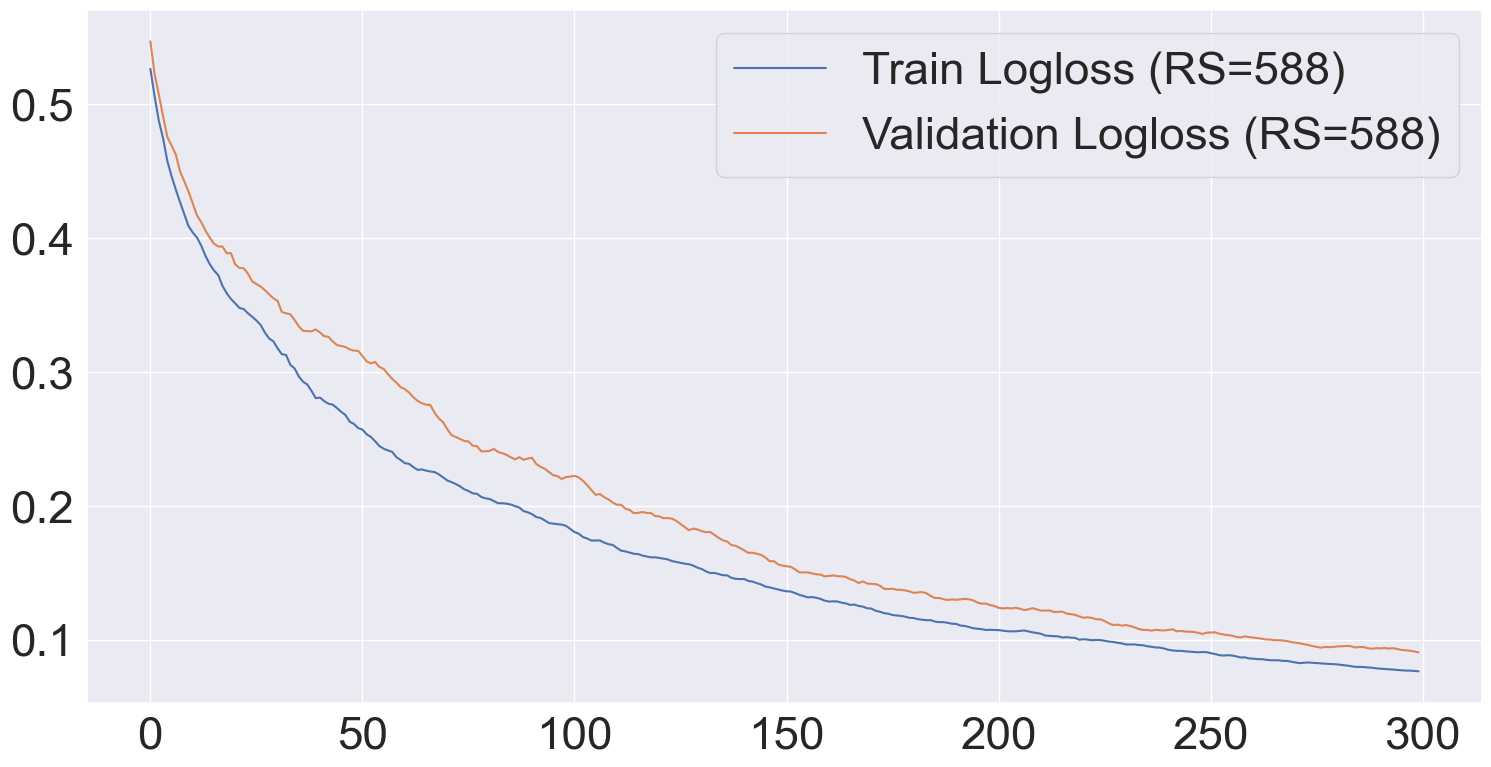

[0]	validation_0-logloss:0.54059	validation_1-logloss:0.55703
[1]	validation_0-logloss:0.53140	validation_1-logloss:0.54750
[2]	validation_0-logloss:0.52236	validation_1-logloss:0.53877
[3]	validation_0-logloss:0.51337	validation_1-logloss:0.53001
[4]	validation_0-logloss:0.50773	validation_1-logloss:0.52336
[5]	validation_0-logloss:0.50267	validation_1-logloss:0.51882
[6]	validation_0-logloss:0.49870	validation_1-logloss:0.51484
[7]	validation_0-logloss:0.49625	validation_1-logloss:0.51185
[8]	validation_0-logloss:0.49263	validation_1-logloss:0.50684
[9]	validation_0-logloss:0.48899	validation_1-logloss:0.50258
[10]	validation_0-logloss:0.48727	validation_1-logloss:0.49999
[11]	validation_0-logloss:0.48516	validation_1-logloss:0.49743
[12]	validation_0-logloss:0.48072	validation_1-logloss:0.49353
[13]	validation_0-logloss:0.47792	validation_1-logloss:0.49184
[14]	validation_0-logloss:0.47800	validation_1-logloss:0.49087
[15]	validation_0-logloss:0.47712	validation_1-logloss:0.49028
[1

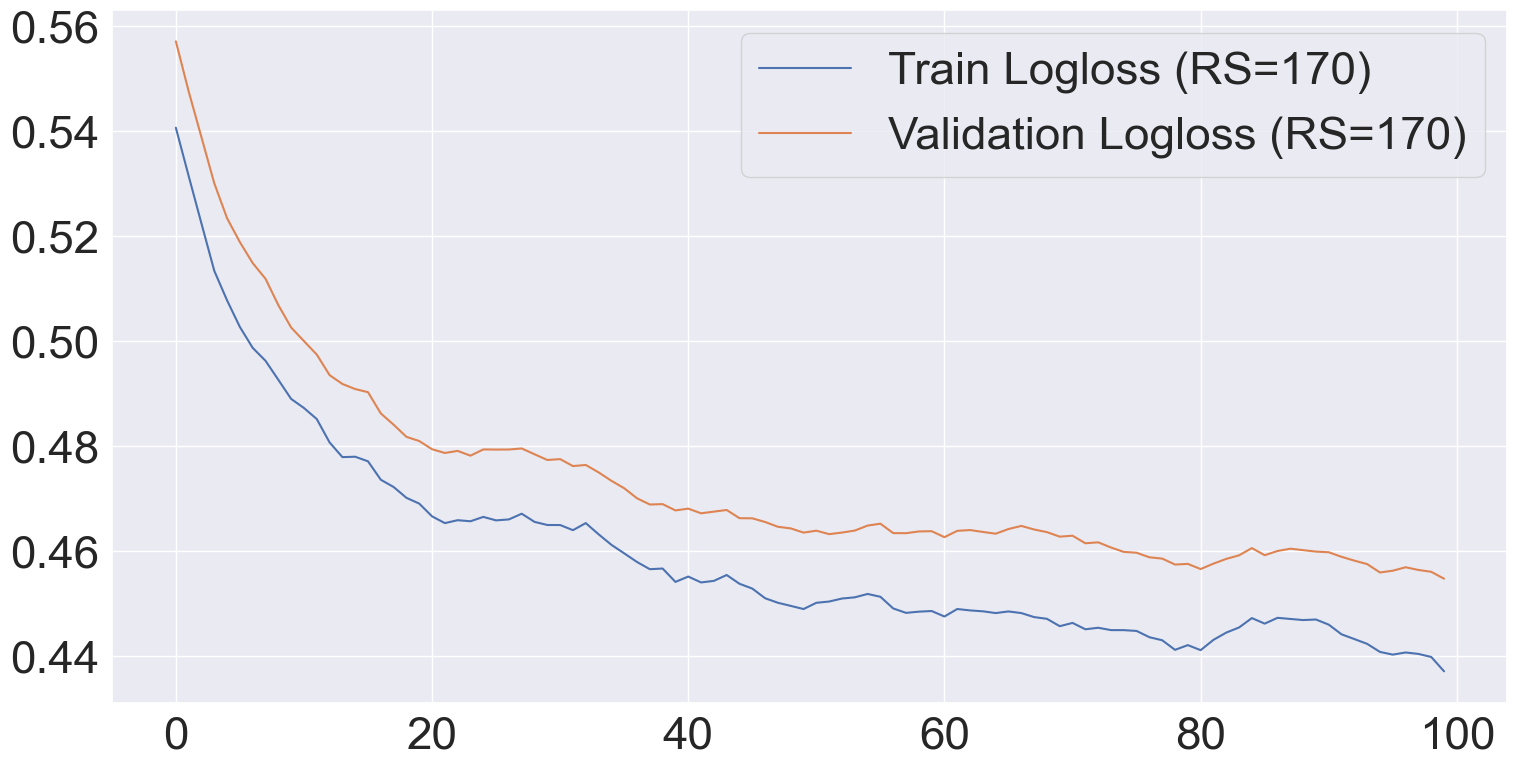

[0]	validation_0-logloss:0.49256	validation_1-logloss:0.51173
[1]	validation_0-logloss:0.44922	validation_1-logloss:0.47070
[2]	validation_0-logloss:0.42217	validation_1-logloss:0.44105
[3]	validation_0-logloss:0.40229	validation_1-logloss:0.41279
[4]	validation_0-logloss:0.38499	validation_1-logloss:0.40116
[5]	validation_0-logloss:0.36975	validation_1-logloss:0.38413
[6]	validation_0-logloss:0.35423	validation_1-logloss:0.36993
[7]	validation_0-logloss:0.34715	validation_1-logloss:0.35938
[8]	validation_0-logloss:0.34022	validation_1-logloss:0.35251
[9]	validation_0-logloss:0.33063	validation_1-logloss:0.34783
[10]	validation_0-logloss:0.32355	validation_1-logloss:0.33846
[11]	validation_0-logloss:0.31317	validation_1-logloss:0.33195
[12]	validation_0-logloss:0.30397	validation_1-logloss:0.32397
[13]	validation_0-logloss:0.29526	validation_1-logloss:0.31486
[14]	validation_0-logloss:0.29003	validation_1-logloss:0.30924
[15]	validation_0-logloss:0.28272	validation_1-logloss:0.30222
[1

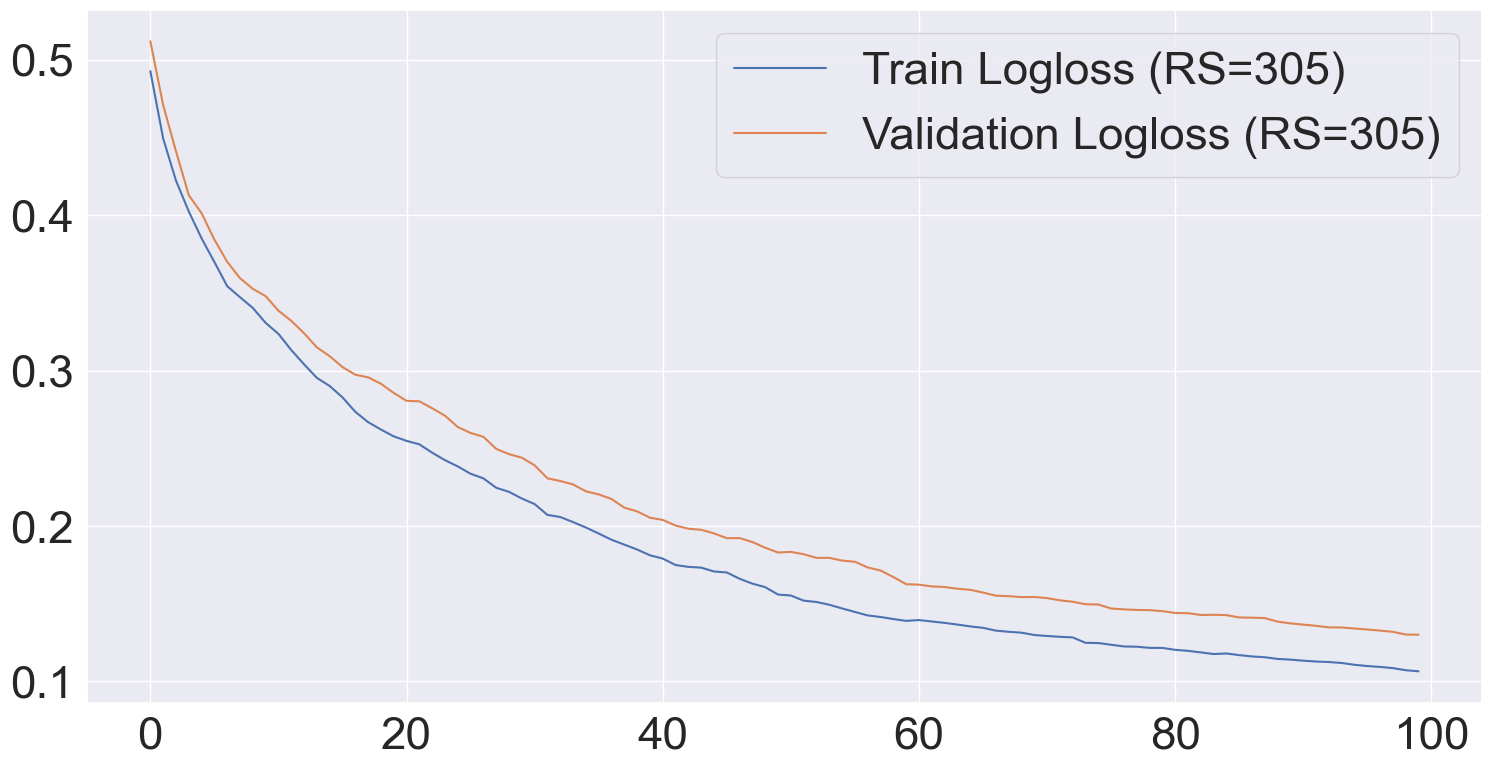

[0]	validation_0-logloss:0.54207	validation_1-logloss:0.56217
[1]	validation_0-logloss:0.53479	validation_1-logloss:0.55848
[2]	validation_0-logloss:0.52704	validation_1-logloss:0.54931
[3]	validation_0-logloss:0.52133	validation_1-logloss:0.54438
[4]	validation_0-logloss:0.51451	validation_1-logloss:0.53803
[5]	validation_0-logloss:0.50895	validation_1-logloss:0.53244
[6]	validation_0-logloss:0.50413	validation_1-logloss:0.52705
[7]	validation_0-logloss:0.49975	validation_1-logloss:0.52138
[8]	validation_0-logloss:0.49589	validation_1-logloss:0.51817
[9]	validation_0-logloss:0.49274	validation_1-logloss:0.51401
[10]	validation_0-logloss:0.48885	validation_1-logloss:0.51126
[11]	validation_0-logloss:0.48611	validation_1-logloss:0.50778
[12]	validation_0-logloss:0.48263	validation_1-logloss:0.50436
[13]	validation_0-logloss:0.48045	validation_1-logloss:0.50206
[14]	validation_0-logloss:0.47805	validation_1-logloss:0.49931
[15]	validation_0-logloss:0.47671	validation_1-logloss:0.49813
[1

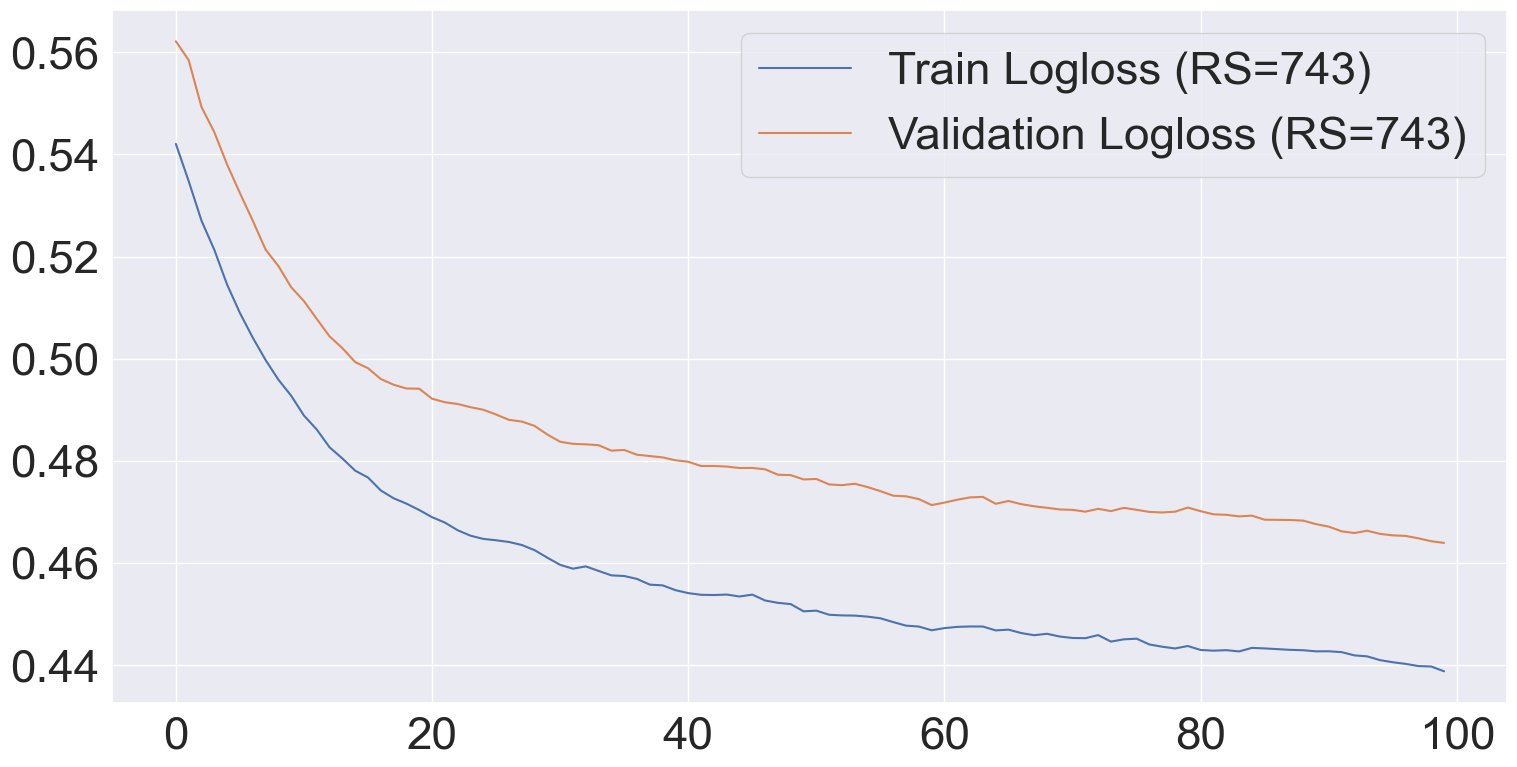

[0]	validation_0-logloss:0.54142	validation_1-logloss:0.55528
[1]	validation_0-logloss:0.53454	validation_1-logloss:0.54747
[2]	validation_0-logloss:0.52403	validation_1-logloss:0.53722
[3]	validation_0-logloss:0.51661	validation_1-logloss:0.53121
[4]	validation_0-logloss:0.50992	validation_1-logloss:0.52408
[5]	validation_0-logloss:0.50537	validation_1-logloss:0.52047
[6]	validation_0-logloss:0.50185	validation_1-logloss:0.51723
[7]	validation_0-logloss:0.49844	validation_1-logloss:0.51405
[8]	validation_0-logloss:0.49501	validation_1-logloss:0.50925
[9]	validation_0-logloss:0.49133	validation_1-logloss:0.50470
[10]	validation_0-logloss:0.48971	validation_1-logloss:0.50258
[11]	validation_0-logloss:0.48905	validation_1-logloss:0.50124
[12]	validation_0-logloss:0.48550	validation_1-logloss:0.49782
[13]	validation_0-logloss:0.48327	validation_1-logloss:0.49526
[14]	validation_0-logloss:0.48146	validation_1-logloss:0.49292
[15]	validation_0-logloss:0.47864	validation_1-logloss:0.49033
[1

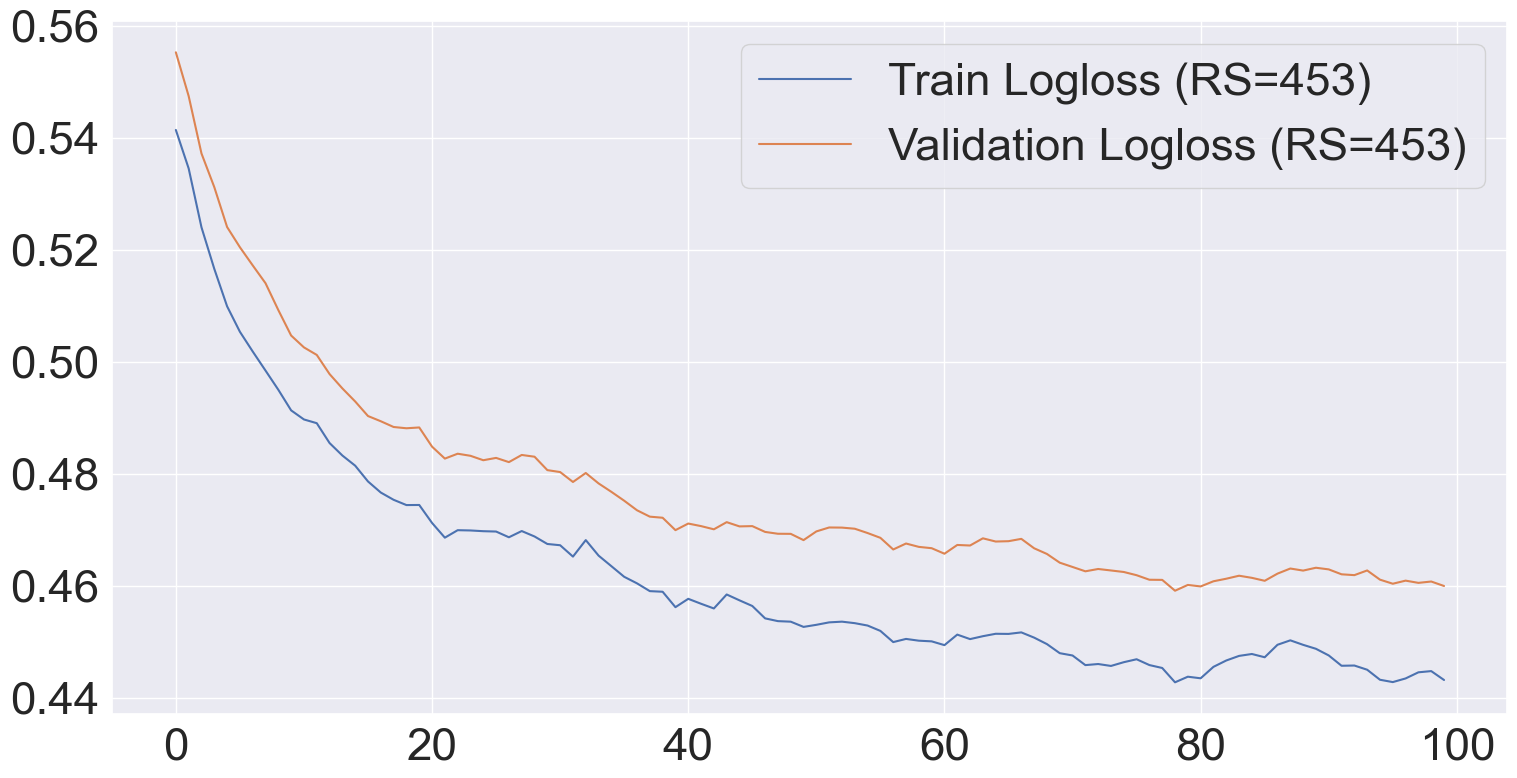

Average Accuracy: 0.8715277777777778
Average Precision: 0.7167572463768116
Average Recall: 0.6666666666666666
Average F1 Score: 0.6881230854915065
Averaged Hyperparameters:
colsample_bytree      0.616667
learning_rate         0.133333
max_depth             3.000000
min_child_weight      1.333333
n_estimators        133.333333
reg_alpha             0.616667
reg_lambda            0.666667
scale_pos_weight      1.951430
subsample             0.666667
dtype: float64


In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
import xgboost as xgb

cv = StratifiedKFold(n_splits=10)

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
best_hyperparams_list = []

for _ in range(6):

    rs = np.random.randint(1, 1000)
    
    bayes_search = BayesSearchCV(xgb_model_adjusted, param_grid, cv=cv, n_iter= 20, n_jobs=-1, random_state = rs, fit_params = fit_params)
    evalset = [(train_x, train_y), (test_x, test_y)]
    bayes_search.fit(X_adjusted, y, eval_set=evalset)

    xgb_best_model = bayes_search.best_estimator_
    results = xgb_best_model.evals_result()

    pyplot.plot(results['validation_0']['logloss'], label=f'Train Logloss (RS={rs})')
    pyplot.plot(results['validation_1']['logloss'], label=f'Validation Logloss (RS={rs})')

    pyplot.legend()
    pyplot.show()

    y_pred = xgb_best_model.predict(test_x)
    y_pred_prob = xgb_best_model.predict_proba(test_x)[:, 1]

    accuracy = accuracy_score(test_y, y_pred)
    precision = precision_score(test_y, y_pred)
    recall = recall_score(test_y, y_pred)
    f1 = f1_score(test_y, y_pred)

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    best_hyperparams_list.append(bayes_search.best_params_)


print("Average Accuracy:", np.mean(accuracy_list))
print("Average Precision:", np.mean(precision_list))
print("Average Recall:", np.mean(recall_list))
print("Average F1 Score:", np.mean(f1_list))

hyperparams_df = pd.DataFrame(best_hyperparams_list)
averaged_hyperparams = hyperparams_df.mean()
print("Averaged Hyperparameters:")
print(averaged_hyperparams)

In [121]:
from sklearn.model_selection import permutation_test_score

score, permutation_scores, pvalue = permutation_test_score(
    xgb_model_adjusted, X_adjusted, y, random_state=0
)


In [122]:
pvalue

0.009900990099009901

In [84]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score

xgb_best_model = bayes_search.best_estimator_

y_true = test_y 

y_pred = xgb_best_model.predict(test_x[x_var_adjusted])
y_pred_prob = xgb_best_model.predict_proba(test_x[x_var_adjusted])[:, 1]  

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc_pr = average_precision_score(y_true, y_pred_prob)

print("Accuracy:", round(accuracy, 2))
print("Precision:", round(precision, 2))
print("Recall:", round(recall, 2))
print("F1 Score:", round(f1, 2))
print("AUC PR:", round(auc_pr, 2))


Accuracy: 0.99
Precision: 0.93
Recall: 1.0
F1 Score: 0.96
AUC PR: 1.0


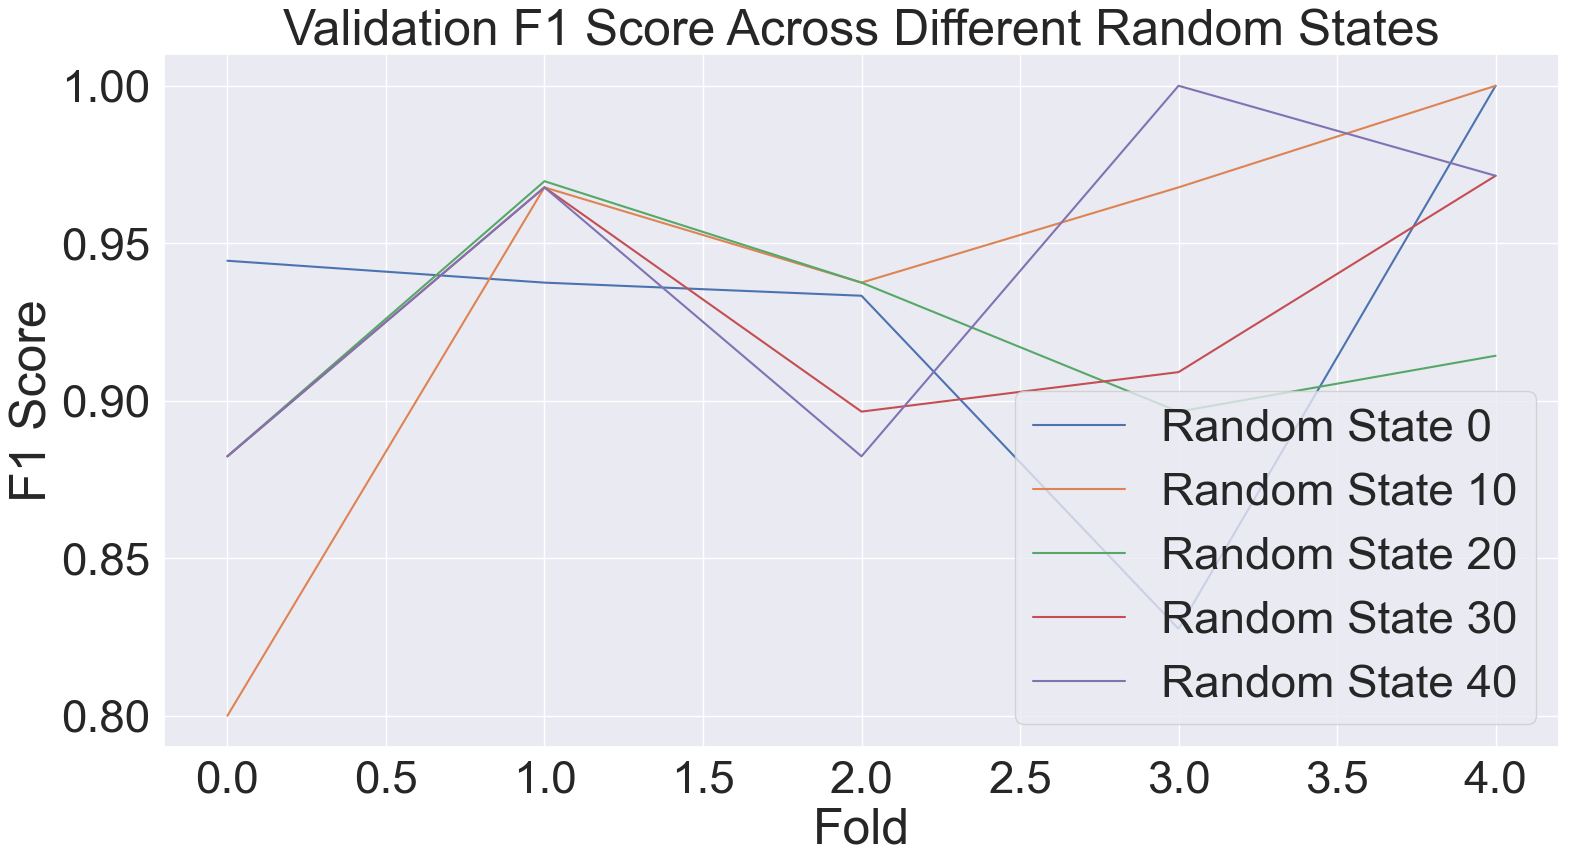

In [69]:
import matplotlib.pyplot as plt

random_states = [0, 10, 20, 30, 40]
for rs in random_states:
    train_scores = []
    val_scores = []
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)
    for train_idx, val_idx in cv.split(X, y):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]
        
        model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
        model.fit(train_x, train_y)
        
        train_pred = model.predict(train_x)
        val_pred = model.predict(val_x)
        
        train_scores.append(f1_score(train_y, train_pred))
        val_scores.append(f1_score(val_y, val_pred))

    plt.plot(val_scores, label=f'Random State {rs}')
    
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score Across Different Random States')
plt.legend()
plt.show()


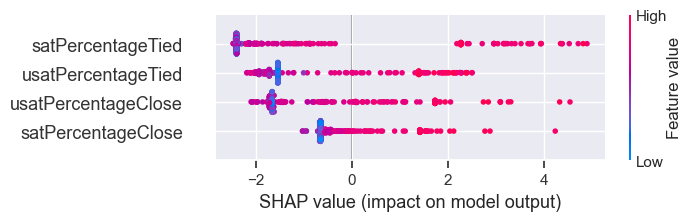

In [67]:
import shap

explainer = shap.Explainer(xgb_best_model)
shap_values = explainer(train_xgb[x_var_adjusted])

shap.summary_plot(shap_values, train_xgb[x_var_adjusted])

In [42]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0], train_xgb[x_var_adjusted].iloc[0])

NameError: name 'shap' is not defined

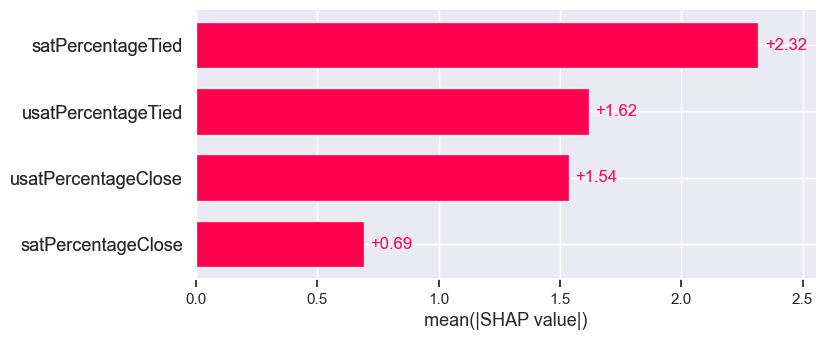

In [73]:
shap.plots.bar(shap_values)

In [102]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score

train_xgb, test_xgb = train_test_split(random_sample, test_size=0.2, random_state=42)

evalset = [(train_xgb[x_var_adjusted], train_xgb[y_var]), (test_xgb[x_var_adjusted], test_xgb[y_var])]

xgb_best_model.fit(train_xgb[x_var_adjusted], train_xgb[y_var], eval_set=evalset, verbose=True)

y_pred_final = xgb_best_model.predict(test_xgb[x_var_adjusted])
y_pred_prob_final = xgb_best_model.predict_proba(test_xgb[x_var_adjusted])[:, 1]

[0]	validation_0-logloss:0.56224	validation_1-logloss:0.56961
[1]	validation_0-logloss:0.50006	validation_1-logloss:0.50637
[2]	validation_0-logloss:0.44693	validation_1-logloss:0.45241
[3]	validation_0-logloss:0.40412	validation_1-logloss:0.41778
[4]	validation_0-logloss:0.36397	validation_1-logloss:0.37638
[5]	validation_0-logloss:0.32892	validation_1-logloss:0.34022
[6]	validation_0-logloss:0.29815	validation_1-logloss:0.30847
[7]	validation_0-logloss:0.27102	validation_1-logloss:0.28047
[8]	validation_0-logloss:0.24892	validation_1-logloss:0.26310
[9]	validation_0-logloss:0.22739	validation_1-logloss:0.24049
[10]	validation_0-logloss:0.20823	validation_1-logloss:0.22035
[11]	validation_0-logloss:0.19113	validation_1-logloss:0.20236
[12]	validation_0-logloss:0.17583	validation_1-logloss:0.18625
[13]	validation_0-logloss:0.16210	validation_1-logloss:0.17179
[14]	validation_0-logloss:0.14977	validation_1-logloss:0.15879
[15]	validation_0-logloss:0.13868	validation_1-logloss:0.14708
[1

In [103]:
y_true = test_xgb[y_var]
y_pred = xgb_best_model.predict(test_xgb[x_var_adjusted])
y_pred_prob = xgb_best_model.predict_proba(test_xgb[x_var_adjusted])[:, 1]  

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

auc_pr = average_precision_score(y_true, y_pred_prob)

print("Accuracy:", round(accuracy,2))
print("Precision:", round(precision,2))
print("Recall:", round(recall,2))
print("F1 Score:", round(f1,2))
print("AUC PR:", round(auc_pr,2))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC PR: 1.0


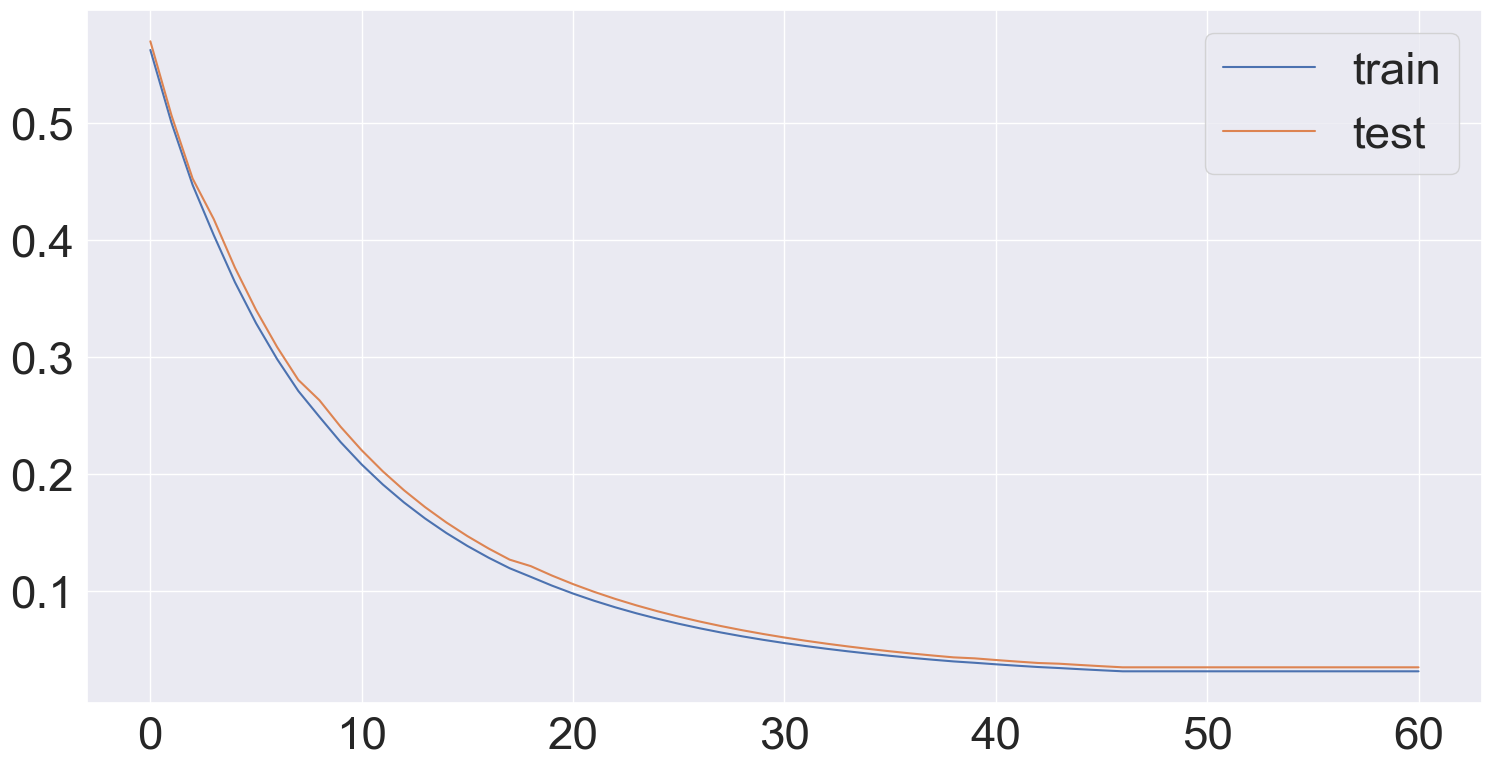

In [104]:
results = xgb_best_model.evals_result()

pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='test')
pyplot.legend()
pyplot.show()

In [171]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score

# Step 1: Use the best model to make predictions on the test set
y_true = df_test['clutch_performance']  # True labels from the test set
y_pred = xgb_best_model.predict(df_test[x_var_adjusted])  # Make predictions

# Step 2: Calculate performance metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc_pr = average_precision_score(y_true, xgb_best_model.predict_proba(df_test[x_var_adjusted])[:, 1])  # AUC-PR

# Step 3: Print the results
print("Test Set Metrics:")
print("Accuracy:", round(accuracy, 2))
print("Precision:", round(precision, 2))
print("Recall:", round(recall, 2))
print("F1 Score:", round(f1, 2))
print("AUC PR:", round(auc_pr, 2))

Test Set Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC PR: 1.0


In [33]:
xgb_model.fit(train_xgb[x_var_adjusted], train_xgb[y_var])

y_train_pred = xgb_model.predict(train_xgb[x_var_adjusted])

y_test_pred = xgb_model.predict(test_xgb[x_var_adjusted])

train_accuracy = accuracy_score(train_xgb[y_var], y_train_pred)
train_precision = precision_score(train_xgb[y_var], y_train_pred)
train_recall = recall_score(train_xgb[y_var], y_train_pred)
train_f1 = f1_score(train_xgb[y_var], y_train_pred)

# Print results
print("Training Set Metrics:")
print(f"Accuracy: {train_accuracy:.2f}, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1 Score: {train_f1:.2f}")


Training Set Metrics:
Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1 Score: 1.00


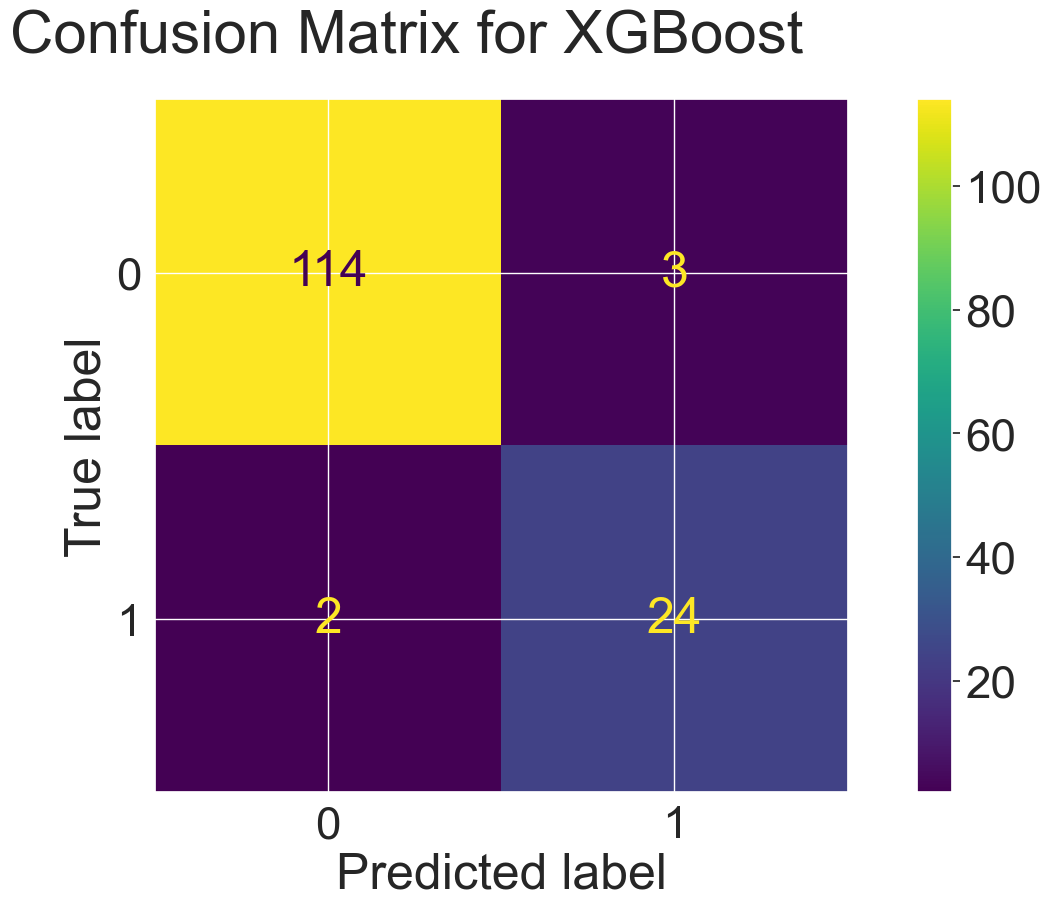

In [160]:
conf_matrix = confusion_matrix(y_pred_xgb, y_true_xgb)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.suptitle('Confusion Matrix for XGBoost')
plt.show()

In [156]:
x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = ['clutch_performance']
train, test = train_test_split(df_players_merged, test_size = 0.3)

random_forest_model = RandomForestClassifier(n_estimators=100)
random_forest_model.fit(train[x_var], train[y_var].values.ravel())

RandomForestClassifier()

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time

x_var_adjusted = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageTied']
y_var = 'clutch_performance'

scale_pos_weight = (df_players_merged['clutch_performance'] == 0).sum() / (df_players_merged['clutch_performance'] == 1).sum()

param_grid = {
    'max_depth': [1, 3, 5, 7],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [scale_pos_weight],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.1, 0.3, 0.6, 0.8, 1.0],
    'reg_alpha': [0.1, 0.5, 1.0],
    'reg_lambda':[0.1, 0.5, 1.0]
    
}

random_search = RandomizedSearchCV(estimator = xgb_model, param_distributions = param_grid, cv = 5, n_jobs = -1,n_iter=100)

start_time = time.time()
random_search.fit(train_xgb[x_var_adjusted], train_xgb[y_var])
xgb_duration = time.time() - start_time

print("Best Parameters:", random_search.best_params_)
print ("Time: ", xgb_duration)

In [97]:
scores = cross_val_score(xgb_model, df_players_merged[x_var], df_players_merged[y_var].values.ravel(), cv=10)
scores

array([1.        , 0.97916667, 0.95833333, 1.        , 0.97916667,
       0.95833333, 0.9787234 , 1.        , 1.        , 0.95744681])

In [98]:
scores.mean()

0.9811170212765958

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'subsample': 0.65, 'scale_pos_weight': 4.804878048780488, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 1, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.75}
Best Balanced Accuracy: 0.9749943039416724


In [101]:
best_model = random_search.best_estimator_
best_model.fit(train[x_var], train[y_var])

accuracy = best_model.score(test[x_var], test[y_var])
print("Accuracy:", accuracy)

Accuracy: 0.9440559440559441


In [102]:
cv_scores = cross_val_score(best_model, df_players_merged[x_var], df_players_merged[y_var], cv=10)

cv_scores

array([0.9375    , 0.97916667, 0.95833333, 0.97916667, 0.97916667,
       0.97916667, 0.95744681, 1.        , 0.9787234 , 0.95744681])

In [103]:
cv_scores.mean()

0.9706117021276597

In [104]:
y_pred = best_model.predict(test[x_var])  
y_true = test[y_var]

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.8055555555555556
Recall: 0.9666666666666667
F1 Score: 0.8787878787878789


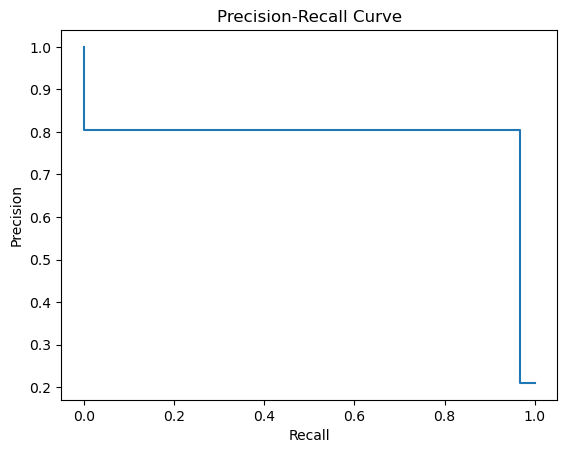

In [105]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

display = PrecisionRecallDisplay(precision=precision, recall=recall)

display.plot()

plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")

plt.show()

In [107]:
probability = best_model.predict_proba(test[x_var])[:, 1]

auc_pr = average_precision_score(test[y_var], probability)

auc_pr

0.9817724867724869

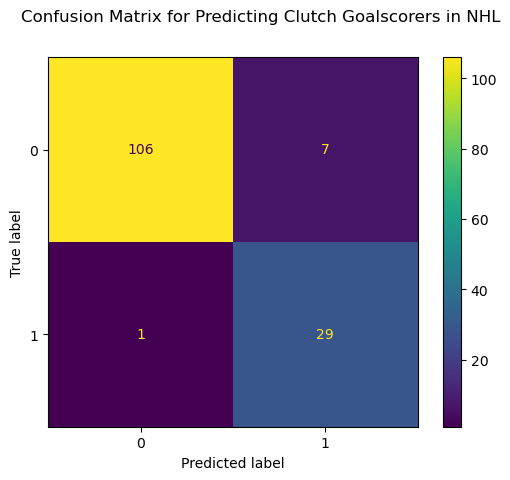

In [108]:
conf_matrix = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.suptitle('Confusion Matrix for Predicting Clutch Goalscorers in NHL')
plt.show()

In [109]:
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix)
accuracy

0.9440559440559441

In [110]:
df_players_merged['gameWinningGoalsPercentile'] = df_players_merged['gameWinningGoalsPercentile'].astype(str) + '%'
df_players_merged['tiedPercentile'] = df_players_merged['tiedPercentile'].astype(str) + '%'
df_players_merged['closePercentile'] = df_players_merged['closePercentile'].astype(str) + '%'
df_players_merged['final'] = df_players_merged['final'].astype(str) + '%'

In [111]:
df_players_merged.to_csv(r'C:\Users\shakj\Desktop\nhl_clutch_player_data1.csv', index=False)

In [112]:
df_players_merged

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,...,satPercentageClosePercentile,satPercentageTiedPercentile,usatPercentageTiedPercentile,usatPercentageClosePercentile,gameWinningGoalsPercentile,tiedPercentile,closePercentile,final,finalRank,clutch_performance
0,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,46.4,43.6,40.1,...,27.94,15.13,3.99,13.76,36.97%,9.56%,20.85%,23.91%,399.0,0
1,8475763,Kevin Hayes,Hayes,R,STL,79,L,45.0,44.3,43.0,...,20.48,18.28,13.76,13.76,55.67%,16.02%,17.12%,32.21%,355.0,0
2,8471698,T.J. Oshie,Oshie,R,WSH,56,R,43.3,41.6,41.1,...,12.82,8.61,7.25,11.55,80.78%,7.93%,12.18%,38.35%,320.0,0
3,8482259,Bobby McMann,McMann,C,TOR,56,L,52.3,51.8,50.9,...,72.90,67.65,59.56,78.36,13.34%,63.6%,75.63%,47.1%,267.0,0
4,8480748,Kiefer Sherwood,Sherwood,L,NSH,74,R,52.0,53.5,53.4,...,70.38,78.26,76.16,70.80,55.67%,77.21%,70.59%,66.61%,123.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,8474870,Tyler Johnson,Johnson,C,CHI,67,R,37.4,37.3,37.7,...,1.16,1.68,2.31,0.84,36.97%,2.0%,1.0%,15.69%,438.0,0
472,8475913,Mark Stone,Stone,R,VGK,63,R,45.5,43.1,42.1,...,21.85,13.34,10.82,20.80,87.82%,12.08%,21.33%,45.15%,281.0,0
473,8478831,Kevin Stenlund,Stenlund,C,FLA,105,R,48.8,51.1,48.8,...,44.33,61.03,43.70,33.82,70.17%,52.36%,39.08%,55.5%,207.0,0
474,8476483,Rickard Rakell,Rakell,R,PIT,70,R,52.7,52.8,52.5,...,76.05,74.16,71.64,66.49,55.67%,72.9%,71.27%,65.52%,130.0,0


In [113]:
df_players_merged['finalRank'] = df_players_merged['finalRank'].astype(int)

df_players_merged.rename(columns={'skaterFullName': 'Name', 'closePercentile': 'Close Percentile', 'tiedPercentile': 'Tied Percentile', 'closePercentile': 'Close Percentile', 'gameWinningGoalsPercentile': 'GWG Percentile', 'final': 'Clutch Percentile','finalRank': 'Rank'}, inplace=True)

df_players_merged[['Name', 'Close Percentile',  'Tied Percentile', 'Clutch Percentile', 'GWG Percentile', 'Rank']].sort_values('Rank', ascending=True).head(5)

,Name,Close Percentile,Tied Percentile,Clutch Percentile,GWG Percentile,Rank
399,Zach Hyman,97.0%,97.38%,97.73%,98.53%,1
188,Sebastian Aho,96.96%,96.12%,97.63%,99.26%,2
12,Seth Jarvis,96.64%,97.38%,97.2%,97.48%,3
252,Andrei Svechnikov,98.37%,94.02%,96.12%,96.01%,4
194,Sam Reinhart,93.48%,93.49%,96.09%,100.0%,5


In [114]:
df_players_merged[['Name', 'Close Percentile',  'Tied Percentile', 'GWG Percentile', 'Clutch Percentile', 'Rank']].sort_values('Rank', ascending=True).head(10)

,Name,Close Percentile,Tied Percentile,GWG Percentile,Clutch Percentile,Rank
399,Zach Hyman,97.0%,97.38%,98.53%,97.73%,1
188,Sebastian Aho,96.96%,96.12%,99.26%,97.63%,2
12,Seth Jarvis,96.64%,97.38%,97.48%,97.2%,3
252,Andrei Svechnikov,98.37%,94.02%,96.01%,96.12%,4
194,Sam Reinhart,93.48%,93.49%,100.0%,96.09%,5
338,Nathan MacKinnon,95.32%,93.65%,97.48%,95.68%,6
110,Aleksander Barkov,94.54%,94.7%,96.01%,95.18%,7
166,Mikko Rantanen,93.38%,91.23%,98.53%,94.8%,8
87,Connor McDavid,97.84%,95.28%,91.6%,94.58%,9
397,Artemi Panarin,90.44%,90.18%,97.48%,93.18%,10
